In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm #progress bar
import rdkit
from rdkit import Chem #Chemistry
from rdkit.Chem import rdMolDescriptors #molecular descriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
rdkit.__version__


'2023.03.2'

In [129]:
import xgboost
import sklearn
import tensorflow as tf
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
from sklearn.model_selection import train_test_split #ML training
from sklearn.model_selection import RandomizedSearchCV
#from yellowbrick.regressor import prediction_error, ResidualsPlot
from tdc.single_pred import ADME
from tdc.benchmark_group import admet_group
from tdc import BenchmarkGroup
import warnings
warnings.filterwarnings("ignore")

In [76]:
def pred_prob_to_score(pred_prob):
    res = []
    for i in range(len(pred_prob)):
        res.append(pred_prob[i][1])
    res = np.array(res)
    return res

In [199]:
group = admet_group(path = 'data/')
predictions_list_xgb = []
best_params_list_xgb = []
predictions_list_rf = []
predictions_list_svm = []
best_params_list_svm = []
predictions_list_adb = []
predictions_list_cnn = []

for seed in [1, 2, 3, 4, 5]:
    predictions_xgb = {}
    predictions_rf = {}
    predictions_svm = {}
    predictions_adb = {}
    predictions_cnn = {}

    benchmark = group.get('Bioavailability_Ma')
    name = benchmark['name']
    train_val, test = benchmark['train_val'], benchmark['test']
    train, valid = group.get_train_valid_split(benchmark = name, split_type = 'default', seed = seed)

    PandasTools.AddMoleculeColumnToFrame(train, smilesCol='Drug')
    radius=2
    nBits=1024
    ECFP6 = [AllChem.GetMorganFingerprintAsBitVect(x,radius=radius, nBits=nBits) for x in train['ROMol']]
    ecfp6_name = [f'Bit_{i}' for i in range(nBits)]
    ecfp6_bits = [list(l) for l in ECFP6]
    Y = train['Y']
    train = pd.DataFrame(ecfp6_bits, index = train.Drug, columns=ecfp6_name).reset_index(drop = False)
    train['Y'] = Y

    PandasTools.AddMoleculeColumnToFrame(benchmark['test'], smilesCol='Drug')
    radius=2
    nBits=1024
    ECFP6 = [AllChem.GetMorganFingerprintAsBitVect(x,radius=radius, nBits=nBits) for x in benchmark['test']['ROMol']]
    ecfp6_name = [f'Bit_{i}' for i in range(nBits)]
    ecfp6_bits = [list(l) for l in ECFP6]
    Y = benchmark['test']['Y']
    benchmark['test'] = pd.DataFrame(ecfp6_bits, index = benchmark['test'].Drug, columns=ecfp6_name).reset_index(drop = False)
    benchmark['test']['Y'] = Y

    train_X = train.drop(columns = ["Drug","Y"])
    train_y = train.Y
    test_X = benchmark['test'].drop(columns = ["Drug","Y"])
    test_y = benchmark['test'].Y


    #XGBoost + Morgan
    xgb_parameters = {'objective':['binary:logistic'],
    'booster':['gbtree','gblinear'],
    'learning_rate': [0.1],
    'max_depth': [7,10,15,20],
    'min_child_weight': [10,15,20,25],
    'colsample_bytree': [0.8, 0.9, 1],
    'n_estimators': [300,400,500,600],
    "reg_alpha"   : [0.5,0.2,1],
    "reg_lambda"  : [2,3,5],
    "gamma"       : [1,2,3]}

    xgb_model = XGBClassifier()
    grid_obj_xgb = RandomizedSearchCV(xgb_model, xgb_parameters, cv=5, n_iter=15, scoring = 'roc_auc', verbose=5, n_jobs=1)
    grid_obj_xgb.fit(train_X, train_y, verbose = 1)
    y_pred_test_xgb = grid_obj_xgb.predict_proba(test_X)
    y_pred_test_xgb = pred_prob_to_score(y_pred_test_xgb)
    bp_xgb = grid_obj_xgb.best_params_
    predictions_xgb[name] = y_pred_test_xgb
    predictions_list_xgb.append(predictions_xgb)
    best_params_list_xgb.append(bp_xgb)

    #Random Forest + Morgan
    rf_model = RandomForestClassifier()
    rf_model.fit(train_X, train_y)
    y_pred_test_rf = rf_model.predict_proba(test_X)
    y_pred_test_rf = pred_prob_to_score(y_pred_test_rf)
    predictions_rf[name] = y_pred_test_rf
    predictions_list_rf.append(predictions_rf)

    #SVM + Morgan
    svm_parameters = {
        'C': [0.1, 1, 10, 100, 1000],
        'gamma': [0.0001, 0.001, 0.01, 0.1, 1]
    }
    svm_model = SVC(kernel="rbf", probability=True)
    grid_obj_svm = RandomizedSearchCV(svm_model, svm_parameters, cv=5, n_iter=15, verbose=5, n_jobs=1)
    grid_obj_svm.fit(train_X, train_y)
    y_pred_test_svm = grid_obj_svm.predict_proba(test_X)
    y_pred_test_svm = pred_prob_to_score(y_pred_test_svm)
    bp_svm = grid_obj_svm.best_params_
    predictions_svm[name] = y_pred_test_svm
    predictions_list_svm.append(predictions_svm)
    best_params_list_svm.append(bp_svm)

    # AdaBoost + Morgan
    DTC = DecisionTreeClassifier(max_depth=4)
    adb_model = AdaBoostClassifier(n_estimators=300, base_estimator=DTC, learning_rate=1)
    adb_model.fit(train_X, train_y)
    y_pred_test_adb = adb_model.predict_proba(test_X)
    y_pred_test_adb = pred_prob_to_score(y_pred_test_adb)
    predictions_adb[name] = y_pred_test_adb
    predictions_list_adb.append(predictions_adb)

    #CNN + Morgan
    train_X = train_X.to_numpy()
    test_X = test_X.to_numpy()
    train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
    test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], 1)
    train_X = train_X.astype('float32')
    test_X = test_X.astype('float32')
    cnn_model = Sequential()
    cnn_model.add(Conv1D(32, 2, padding="valid", activation="relu", input_shape=(1024,1)))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(64, activation="relu"))
    cnn_model.add(Dense(1,activation='sigmoid'))
    cnn_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer="adam", metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.FalseNegatives()])
    cnn_model.fit(train_X, train_y, batch_size=12, epochs=10, verbose=0)
    y_pred_test_cnn = cnn_model.predict(test_X)
    y_pred_test_cnn_copy = []
    for i in range(len(y_pred_test_cnn)):
        y_pred_test_cnn_copy.append(y_pred_test_cnn[i][0])
    predictions_cnn[name] = np.array(y_pred_test_cnn_copy)
    predictions_list_cnn.append(predictions_cnn)

xgb_results = group.evaluate_many(predictions_list_xgb)
rf_results = group.evaluate_many(predictions_list_rf)
svm_results = group.evaluate_many(predictions_list_svm)
adb_results = group.evaluate_many(predictions_list_adb)
cnn_results = group.evaluate_many(predictions_list_cnn)



Found local copy...
generating training, validation splits...
100%|██████████| 512/512 [00:00<00:00, 2774.39it/s]


Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END booster=gbtree, colsample_bytree=1, gamma=1, learning_rate=0.1, max_depth=10, min_child_weight=15, n_estimators=400, objective=binary:logistic, reg_alpha=0.2, reg_lambda=5;, score=0.657 total time=   1.7s
[CV 2/5] END booster=gbtree, colsample_bytree=1, gamma=1, learning_rate=0.1, max_depth=10, min_child_weight=15, n_estimators=400, objective=binary:logistic, reg_alpha=0.2, reg_lambda=5;, score=0.616 total time=   1.7s
[CV 3/5] END booster=gbtree, colsample_bytree=1, gamma=1, learning_rate=0.1, max_depth=10, min_child_weight=15, n_estimators=400, objective=binary:logistic, reg_alpha=0.2, reg_lambda=5;, score=0.702 total time=   1.6s
[CV 4/5] END booster=gbtree, colsample_bytree=1, gamma=1, learning_rate=0.1, max_depth=10, min_child_weight=15, n_estimators=400, objective=binary:logistic, reg_alpha=0.2, reg_lambda=5;, score=0.495 total time=   1.7s
[CV 5/5] END booster=gbtree, colsample_bytree=1, gamma=1, learning_

generating training, validation splits...
100%|██████████| 512/512 [00:00<00:00, 2609.16it/s]


Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END booster=gbtree, colsample_bytree=0.8, gamma=3, learning_rate=0.1, max_depth=7, min_child_weight=25, n_estimators=500, objective=binary:logistic, reg_alpha=1, reg_lambda=2;, score=0.575 total time=   1.9s
[CV 2/5] END booster=gbtree, colsample_bytree=0.8, gamma=3, learning_rate=0.1, max_depth=7, min_child_weight=25, n_estimators=500, objective=binary:logistic, reg_alpha=1, reg_lambda=2;, score=0.491 total time=   2.0s
[CV 3/5] END booster=gbtree, colsample_bytree=0.8, gamma=3, learning_rate=0.1, max_depth=7, min_child_weight=25, n_estimators=500, objective=binary:logistic, reg_alpha=1, reg_lambda=2;, score=0.500 total time=   1.8s
[CV 4/5] END booster=gbtree, colsample_bytree=0.8, gamma=3, learning_rate=0.1, max_depth=7, min_child_weight=25, n_estimators=500, objective=binary:logistic, reg_alpha=1, reg_lambda=2;, score=0.531 total time=   2.4s
[CV 5/5] END booster=gbtree, colsample_bytree=0.8, gamma=3, learning_ra

generating training, validation splits...
100%|██████████| 512/512 [00:00<00:00, 2624.28it/s]


Fitting 5 folds for each of 15 candidates, totalling 75 fits
[23:24:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[CV 1/5] END booster=gblinear, colsample_bytree=1, gamma=2, learning_rate=0.1, max_depth=15, min_child_weight=10, n_estimators=500, objective=binary:logistic, reg_alpha=1, reg_lambda=5;, score=0.500 total time=   1.4s
[23:24:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[CV 2/5] END booster=gblinear, colsample_bytree=1, gamma=2, learning_rate=0.1, max_depth=15, min_child_weight=10, n_estimators=500, objective=binary:logistic, reg_alpha=1, reg_lambda=5;, score=0.500 total time=   1.5s
[23:24:44] WARNING: /Users/runner/work/

generating training, validation splits...
100%|██████████| 512/512 [00:00<00:00, 2603.39it/s]


Fitting 5 folds for each of 15 candidates, totalling 75 fits
[23:27:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[CV 1/5] END booster=gblinear, colsample_bytree=1, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=20, n_estimators=300, objective=binary:logistic, reg_alpha=0.2, reg_lambda=3;, score=0.500 total time=   0.7s
[23:27:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[CV 2/5] END booster=gblinear, colsample_bytree=1, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=20, n_estimators=300, objective=binary:logistic, reg_alpha=0.2, reg_lambda=3;, score=0.500 total time=   0.7s
[23:27:08] WARNING: /Users/runner/wor

generating training, validation splits...
100%|██████████| 512/512 [00:00<00:00, 2628.63it/s]


Fitting 5 folds for each of 15 candidates, totalling 75 fits
[23:29:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[CV 1/5] END booster=gblinear, colsample_bytree=0.9, gamma=3, learning_rate=0.1, max_depth=20, min_child_weight=20, n_estimators=300, objective=binary:logistic, reg_alpha=1, reg_lambda=2;, score=0.500 total time=   0.8s
[23:29:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[CV 2/5] END booster=gblinear, colsample_bytree=0.9, gamma=3, learning_rate=0.1, max_depth=20, min_child_weight=20, n_estimators=300, objective=binary:logistic, reg_alpha=1, reg_lambda=2;, score=0.500 total time=   0.8s
[23:29:26] WARNING: /Users/runner/w

In [200]:
xgb_results

{'bioavailability_ma': [0.601, 0.025]}

In [201]:
rf_results

{'bioavailability_ma': [0.648, 0.016]}

In [202]:
svm_results

{'bioavailability_ma': [0.618, 0.131]}

In [203]:
adb_results

{'bioavailability_ma': [0.633, 0.046]}

In [204]:
cnn_results

{'bioavailability_ma': [0.618, 0.023]}

In [205]:
np.set_printoptions(threshold=np.inf)

In [214]:
predictions_list_cnn

[{'bioavailability_ma': array([0.9999865 , 0.99999404, 0.12115464, 0.10237745, 0.10115429,
         0.9998999 , 0.9999992 , 0.99940956, 0.9943389 , 0.36496636,
         0.9986355 , 0.9980823 , 0.99613255, 0.99973816, 0.92382145,
         0.9988219 , 0.9999741 , 0.43406394, 0.91428894, 0.99610335,
         0.96605086, 0.9945467 , 0.99829715, 0.23429455, 0.999876  ,
         0.99999535, 0.9999931 , 0.9999967 , 0.9996444 , 0.9999662 ,
         0.9997419 , 0.9999907 , 0.9999922 , 0.99983203, 0.9999659 ,
         0.99992794, 0.99966717, 0.98477745, 0.998636  , 0.10753679,
         0.99992347, 0.05633955, 0.99938095, 0.9999889 , 0.99998116,
         0.99984014, 0.44978788, 0.43062943, 0.43062943, 0.15395026,
         0.9695204 , 0.85911864, 0.857992  , 0.03079322, 0.2756041 ,
         0.01706027, 0.03079322, 0.9999922 , 0.9999999 , 0.20980336,
         0.9999922 , 0.9999887 , 0.91828746, 0.4200813 , 0.99504465,
         0.9844884 , 0.47046804, 0.9888751 , 0.32066938, 0.563118  ,
         0.9

In [207]:
predictions_list_xgb = [{'bioavailability_ma': np.array([0.83748347, 0.8475127 , 0.8237392 , 0.6604365 , 0.84774226,
         0.7266247 , 0.7870135 , 0.71055007, 0.73309475, 0.83544767,
         0.7708237 , 0.7188353 , 0.8381136 , 0.90207195, 0.84737384,
         0.8274859 , 0.89120936, 0.7358024 , 0.7681843 , 0.7798125 ,
         0.72267663, 0.72267663, 0.53483415, 0.7148188 , 0.7358024 ,
         0.7728218 , 0.9136106 , 0.82077754, 0.81850547, 0.82308125,
         0.87957996, 0.88283646, 0.8666297 , 0.8649911 , 0.8186935 ,
         0.86085033, 0.70789135, 0.73453397, 0.87766033, 0.89960074,
         0.82746184, 0.73791414, 0.72993195, 0.9137353 , 0.8897096 ,
         0.9014464 , 0.8054535 , 0.71040875, 0.71040875, 0.38439372,
         0.82215816, 0.8345688 , 0.56039786, 0.56039786, 0.56039786,
         0.56039786, 0.56039786, 0.9084728 , 0.9018947 , 0.81319505,
         0.78810525, 0.78810525, 0.79362875, 0.63707924, 0.7169179 ,
         0.7687613 , 0.8603744 , 0.5776433 , 0.8655898 , 0.7427921 ,
         0.81111175, 0.8258021 , 0.9100799 , 0.8944372 , 0.7629286 ,
         0.8225964 , 0.7750993 , 0.89467025, 0.8389291 , 0.6333943 ,
         0.8255199 , 0.8068093 , 0.80452657, 0.82487553, 0.6850255 ,
         0.78944874, 0.84817797, 0.7001546 , 0.8861216 , 0.87139267,
         0.8292808 , 0.8279698 , 0.83494955, 0.89778197, 0.8118252 ,
         0.8784506 , 0.5327184 , 0.61086744, 0.5327184 , 0.7334588 ,
         0.8610148 , 0.72947884, 0.69994676, 0.6994182 , 0.78413564,
         0.8164481 , 0.69628364, 0.7320731 , 0.84373677, 0.7998305 ,
         0.83748347, 0.82620305, 0.83748347, 0.8689669 , 0.8944372 ,
         0.8400608 , 0.86473113, 0.64573103, 0.8176919 , 0.88449967,
         0.826442  , 0.7427921 , 0.8220448 , 0.8570815 , 0.86360687,
         0.72403896, 0.8899683 , 0.86396813])},
 {'bioavailability_ma': np.array([0.6748048 , 0.7884186 , 0.75846994, 0.705362  , 0.6674717 ,
         0.6184784 , 0.79606855, 0.62019175, 0.6364883 , 0.78863925,
         0.71417487, 0.62668025, 0.8543874 , 0.8836355 , 0.8795954 ,
         0.6536737 , 0.87926406, 0.6856286 , 0.7590277 , 0.7455799 ,
         0.7028014 , 0.6856286 , 0.6455569 , 0.66189426, 0.6837434 ,
         0.7447527 , 0.86286217, 0.78568095, 0.8172539 , 0.808192  ,
         0.88610226, 0.8799529 , 0.8799529 , 0.88610226, 0.7955374 ,
         0.8477145 , 0.7623826 , 0.69898313, 0.8477145 , 0.88198614,
         0.7602837 , 0.63242644, 0.82236737, 0.89096195, 0.8356206 ,
         0.8086889 , 0.745209  , 0.7859081 , 0.7859081 , 0.6801785 ,
         0.79506856, 0.7978564 , 0.6534783 , 0.6534783 , 0.6534783 ,
         0.6534783 , 0.6534783 , 0.86271566, 0.8307823 , 0.782352  ,
         0.65692574, 0.65692574, 0.8022529 , 0.70460206, 0.84727895,
         0.7200518 , 0.8552437 , 0.6890257 , 0.84990156, 0.639366  ,
         0.732982  , 0.8269813 , 0.85519034, 0.8017529 , 0.74890524,
         0.7502004 , 0.7267091 , 0.83702946, 0.81751114, 0.6197671 ,
         0.7975058 , 0.7486639 , 0.7389391 , 0.7375046 , 0.73743284,
         0.79407173, 0.82828206, 0.68376553, 0.88610226, 0.8284793 ,
         0.757352  , 0.69906443, 0.7681268 , 0.79209054, 0.66493464,
         0.7884186 , 0.58527446, 0.6527491 , 0.58527446, 0.7451247 ,
         0.81757   , 0.6911745 , 0.5960449 , 0.532794  , 0.7149997 ,
         0.7589252 , 0.6939829 , 0.69175744, 0.79833096, 0.74579805,
         0.6748048 , 0.74012876, 0.6748048 , 0.7799477 , 0.8650159 ,
         0.7644328 , 0.80545783, 0.6384657 , 0.6886555 , 0.812028  ,
         0.7786874 , 0.6465137 , 0.79073256, 0.8215749 , 0.88610226,
         0.67891735, 0.87800545, 0.79165447])},
 {'bioavailability_ma': np.array([0.72148216, 0.75948226, 0.7820633 , 0.7790401 , 0.7383809 ,
         0.75156724, 0.7543368 , 0.6661908 , 0.7327981 , 0.7822343 ,
         0.78357875, 0.7465744 , 0.843596  , 0.843596  , 0.843596  ,
         0.7383809 , 0.82308507, 0.75948226, 0.7907579 , 0.7907579 ,
         0.75948226, 0.75948226, 0.7465744 , 0.7465744 , 0.75948226,
         0.75948226, 0.8215128 , 0.7847109 , 0.7847109 , 0.7847109 ,
         0.85675627, 0.85675627, 0.85675627, 0.85675627, 0.7847109 ,
         0.843596  , 0.75948226, 0.7820633 , 0.843596  , 0.843596  ,
         0.78357875, 0.75156724, 0.74163693, 0.85675627, 0.7653758 ,
         0.78927916, 0.75948226, 0.7773827 , 0.7773827 , 0.7465744 ,
         0.7444771 , 0.80059296, 0.72148216, 0.72148216, 0.72148216,
         0.72148216, 0.72148216, 0.8268124 , 0.79475635, 0.7876776 ,
         0.75156724, 0.7267884 , 0.8219991 , 0.7820633 , 0.7876776 ,
         0.8219991 , 0.843596  , 0.75948226, 0.8112864 , 0.6870483 ,
         0.75948226, 0.79475635, 0.7426461 , 0.7558186 , 0.8219991 ,
         0.8219991 , 0.8219991 , 0.7876776 , 0.8268124 , 0.7267884 ,
         0.80059296, 0.80595857, 0.78927916, 0.7465744 , 0.7790401 ,
         0.8112864 , 0.84678525, 0.75948226, 0.85675627, 0.7822343 ,
         0.75935197, 0.7127894 , 0.75935197, 0.78927916, 0.7383809 ,
         0.75948226, 0.69618803, 0.7327981 , 0.69618803, 0.80059296,
         0.7878454 , 0.72432387, 0.72432387, 0.65875584, 0.7790401 ,
         0.7790401 , 0.7561119 , 0.7333408 , 0.8219991 , 0.7333408 ,
         0.72148216, 0.7561119 , 0.72148216, 0.7561119 , 0.80445236,
         0.78927916, 0.80595857, 0.75156724, 0.75156724, 0.7907579 ,
         0.75948226, 0.6870483 , 0.80059296, 0.80230504, 0.85675627,
         0.7333408 , 0.85675627, 0.80230504])},
 {'bioavailability_ma': np.array([0.7959542 , 0.8286214 , 0.84705675, 0.7397477 , 0.81019545,
         0.7757048 , 0.8035207 , 0.71842086, 0.6846872 , 0.8273011 ,
         0.78799367, 0.7638538 , 0.8557924 , 0.9136889 , 0.8430152 ,
         0.76584923, 0.9067745 , 0.7927313 , 0.8026726 , 0.8254442 ,
         0.7668973 , 0.7528287 , 0.59657574, 0.7548923 , 0.7927313 ,
         0.7216761 , 0.923425  , 0.75023437, 0.7676131 , 0.7588166 ,
         0.9035747 , 0.89924926, 0.89924926, 0.9035747 , 0.7592447 ,
         0.89924926, 0.68640095, 0.80239016, 0.89924926, 0.92116445,
         0.7516461 , 0.7839104 , 0.7861058 , 0.92630696, 0.8790967 ,
         0.8615355 , 0.74808735, 0.6763738 , 0.6763738 , 0.51460046,
         0.84705675, 0.78201884, 0.49601313, 0.51048374, 0.51048374,
         0.51048374, 0.51048374, 0.9165677 , 0.8937306 , 0.86906254,
         0.73844075, 0.73844075, 0.73499125, 0.7226785 , 0.76031923,
         0.75091356, 0.8865838 , 0.6507851 , 0.855552  , 0.6397926 ,
         0.7449707 , 0.84539485, 0.90731823, 0.84084284, 0.72707456,
         0.8202347 , 0.74933636, 0.8988179 , 0.8507088 , 0.64968973,
         0.77250326, 0.78752536, 0.82493126, 0.7693293 , 0.72811663,
         0.8252413 , 0.84371537, 0.6785873 , 0.92101   , 0.8449987 ,
         0.74359405, 0.7609644 , 0.75276494, 0.8556254 , 0.7694868 ,
         0.8633237 , 0.4512016 , 0.6019627 , 0.4512016 , 0.7720732 ,
         0.882618  , 0.5619932 , 0.53913724, 0.62732524, 0.7842347 ,
         0.6884582 , 0.71037966, 0.709591  , 0.8209222 , 0.78059447,
         0.7959542 , 0.7501535 , 0.7959542 , 0.82420796, 0.8912129 ,
         0.8581538 , 0.78484434, 0.71641594, 0.7871057 , 0.85339326,
         0.82451606, 0.6397926 , 0.7930181 , 0.87775564, 0.8625598 ,
         0.699458  , 0.92101   , 0.87708104])},
 {'bioavailability_ma': np.array([0.772344  , 0.69759554, 0.73980844, 0.77711374, 0.73643607,
         0.6832578 , 0.865163  , 0.76316637, 0.82804894, 0.87010694,
         0.7672402 , 0.7792777 , 0.85849667, 0.8921628 , 0.8411161 ,
         0.7415757 , 0.91891706, 0.7179247 , 0.81790835, 0.8213765 ,
         0.7131494 , 0.6992478 , 0.55744797, 0.7131494 , 0.7179247 ,
         0.6832748 , 0.9104718 , 0.8201337 , 0.7933059 , 0.8201337 ,
         0.8919601 , 0.8975283 , 0.8975283 , 0.8919601 , 0.7933059 ,
         0.88776594, 0.5362383 , 0.68112856, 0.9016257 , 0.86292255,
         0.7716369 , 0.644855  , 0.7118494 , 0.9212747 , 0.871444  ,
         0.8363591 , 0.5892132 , 0.8111109 , 0.8111109 , 0.39611393,
         0.7898125 , 0.7585575 , 0.39457875, 0.3740261 , 0.39457875,
         0.39457875, 0.3740261 , 0.91246635, 0.87771404, 0.81237996,
         0.65328956, 0.622681  , 0.7661936 , 0.585537  , 0.77063715,
         0.7328014 , 0.9009454 , 0.59884906, 0.8597395 , 0.5979282 ,
         0.7154418 , 0.87171006, 0.8812782 , 0.81422335, 0.7278559 ,
         0.8107147 , 0.7397891 , 0.8596687 , 0.8746617 , 0.6609775 ,
         0.7675272 , 0.77321976, 0.778317  , 0.7924157 , 0.70691246,
         0.8360721 , 0.84502625, 0.7945118 , 0.9222784 , 0.8405611 ,
         0.64168173, 0.67290485, 0.6672599 , 0.8391207 , 0.6704777 ,
         0.7638915 , 0.51614225, 0.6345183 , 0.51614225, 0.8162589 ,
         0.8990374 , 0.63512814, 0.56954515, 0.68020064, 0.7937035 ,
         0.75295955, 0.7211853 , 0.76151204, 0.8209409 , 0.7941751 ,
         0.772344  , 0.77384675, 0.772344  , 0.8106165 , 0.89771587,
         0.8362914 , 0.7857528 , 0.6872671 , 0.68923265, 0.86539906,
         0.81375885, 0.6073849 , 0.81195253, 0.8757169 , 0.8974072 ,
         0.76151204, 0.9222784 , 0.80569386])}]

In [209]:
predictions_list_rf = [{'bioavailability_ma': np.array([0.81, 0.66, 0.78, 0.63, 0.73, 0.83, 0.83, 0.45, 0.74, 0.55, 0.93,
         0.82, 0.93, 0.94, 0.73, 0.97, 0.95, 0.65, 0.63, 0.84, 0.8 , 0.79,
         0.76, 0.69, 0.83, 0.89, 0.9 , 0.84, 0.86, 0.83, 0.88, 0.92, 0.86,
         0.85, 0.88, 0.75, 0.72, 0.75, 0.75, 0.84, 0.92, 0.63, 0.8 , 0.86,
         0.94, 0.85, 0.86, 0.8 , 0.8 , 0.7 , 0.69, 0.75, 0.5 , 0.53, 0.6 ,
         0.53, 0.53, 0.82, 0.78, 0.63, 0.86, 0.85, 0.73, 0.68, 0.74, 0.79,
         0.58, 0.81, 0.82, 0.65, 0.9 , 0.86, 0.61, 0.98, 0.72, 0.66, 0.66,
         0.82, 0.86, 0.84, 0.87, 0.97, 0.88, 0.8 , 0.76, 0.75, 0.94, 0.57,
         0.85, 0.91, 0.88, 0.97, 0.88, 0.88, 0.8 , 0.92, 0.67, 0.78, 0.67,
         0.94, 0.78, 0.62, 0.5 , 0.36, 0.77, 0.78, 0.45, 0.52, 0.83, 0.8 ,
         0.79, 0.77, 0.79, 0.89, 0.86, 0.81, 0.82, 0.8 , 0.83, 0.91, 0.97,
         0.64, 0.89, 0.73, 0.97, 0.58, 0.82, 0.75])},
 {'bioavailability_ma': np.array([0.86, 0.82, 0.66, 0.63, 0.78, 0.81, 0.84, 0.54, 0.74, 0.63, 0.82,
         0.69, 0.95, 0.91, 0.78, 0.93, 0.95, 0.7 , 0.57, 0.86, 0.78, 0.8 ,
         0.81, 0.7 , 0.79, 0.82, 0.93, 0.76, 0.85, 0.77, 0.9 , 0.81, 0.78,
         0.89, 0.84, 0.69, 0.71, 0.71, 0.72, 0.74, 0.9 , 0.57, 0.77, 0.87,
         0.89, 0.74, 0.82, 0.73, 0.73, 0.67, 0.72, 0.67, 0.65, 0.69, 0.61,
         0.56, 0.69, 0.76, 0.86, 0.68, 0.82, 0.78, 0.84, 0.65, 0.76, 0.81,
         0.66, 0.91, 0.82, 0.43, 0.76, 0.88, 0.65, 0.92, 0.56, 0.62, 0.66,
         0.78, 0.84, 0.84, 0.94, 0.87, 0.8 , 0.88, 0.75, 0.71, 0.83, 0.57,
         0.81, 0.79, 0.86, 0.89, 0.92, 0.95, 0.79, 0.78, 0.66, 0.74, 0.66,
         0.88, 0.7 , 0.55, 0.49, 0.42, 0.73, 0.74, 0.31, 0.52, 0.85, 0.74,
         0.72, 0.78, 0.72, 0.86, 0.83, 0.77, 0.88, 0.82, 0.73, 0.82, 0.93,
         0.43, 0.73, 0.82, 0.96, 0.6 , 0.8 , 0.66])},
 {'bioavailability_ma': np.array([0.74, 0.79, 0.8 , 0.78, 0.65, 0.77, 0.83, 0.54, 0.65, 0.5 , 0.9 ,
         0.79, 0.92, 0.9 , 0.8 , 0.95, 0.9 , 0.75, 0.62, 0.85, 0.85, 0.82,
         0.77, 0.75, 0.82, 0.83, 0.85, 0.78, 0.81, 0.77, 0.96, 0.91, 0.86,
         0.95, 0.86, 0.74, 0.74, 0.87, 0.67, 0.81, 0.92, 0.58, 0.75, 0.91,
         0.94, 0.79, 0.77, 0.63, 0.63, 0.81, 0.72, 0.68, 0.48, 0.53, 0.44,
         0.51, 0.53, 0.81, 0.85, 0.69, 0.88, 0.84, 0.79, 0.81, 0.8 , 0.8 ,
         0.54, 0.81, 0.81, 0.4 , 0.86, 0.9 , 0.6 , 0.84, 0.76, 0.64, 0.66,
         0.89, 0.9 , 0.74, 0.92, 0.94, 0.9 , 0.88, 0.79, 0.69, 0.88, 0.54,
         0.78, 0.91, 0.87, 0.9 , 0.93, 0.92, 0.74, 0.92, 0.63, 0.69, 0.63,
         0.87, 0.75, 0.56, 0.53, 0.43, 0.71, 0.73, 0.24, 0.49, 0.79, 0.86,
         0.75, 0.7 , 0.75, 0.84, 0.84, 0.77, 0.78, 0.7 , 0.84, 0.9 , 0.97,
         0.44, 0.86, 0.79, 0.95, 0.49, 0.83, 0.75])},
 {'bioavailability_ma': np.array([0.81, 0.82, 0.79, 0.73, 0.75, 0.84, 0.88, 0.62, 0.77, 0.9 , 0.88,
         0.84, 0.92, 0.92, 0.79, 0.89, 0.99, 0.71, 0.72, 0.82, 0.84, 0.76,
         0.72, 0.77, 0.77, 0.87, 0.94, 0.78, 0.9 , 0.76, 0.93, 0.86, 0.84,
         0.94, 0.93, 0.79, 0.74, 0.81, 0.78, 0.82, 0.87, 0.6 , 0.79, 0.91,
         0.96, 0.82, 0.89, 0.72, 0.72, 0.74, 0.69, 0.85, 0.61, 0.67, 0.73,
         0.68, 0.67, 0.8 , 0.82, 0.6 , 0.85, 0.86, 0.69, 0.85, 0.83, 0.78,
         0.93, 0.73, 0.9 , 0.46, 0.75, 0.83, 0.59, 0.88, 0.82, 0.8 , 0.76,
         0.87, 0.88, 0.79, 0.9 , 0.92, 0.88, 0.82, 0.75, 0.71, 0.91, 0.58,
         0.84, 0.87, 0.85, 0.96, 0.92, 0.87, 0.64, 0.93, 0.63, 0.66, 0.63,
         0.9 , 0.66, 0.61, 0.59, 0.46, 0.7 , 0.69, 0.61, 0.55, 0.82, 0.82,
         0.72, 0.85, 0.72, 0.94, 0.79, 0.82, 0.83, 0.74, 0.75, 0.84, 0.9 ,
         0.4 , 0.79, 0.87, 0.97, 0.51, 0.82, 0.59])},
 {'bioavailability_ma': np.array([0.82, 0.76, 0.68, 0.59, 0.8 , 0.82, 0.89, 0.62, 0.76, 0.66, 0.86,
         0.74, 0.87, 0.93, 0.75, 0.93, 0.92, 0.7 , 0.61, 0.83, 0.69, 0.78,
         0.71, 0.68, 0.81, 0.73, 0.91, 0.8 , 0.73, 0.76, 0.84, 0.85, 0.77,
         0.85, 0.8 , 0.73, 0.78, 0.83, 0.66, 0.84, 0.84, 0.62, 0.75, 0.93,
         0.92, 0.78, 0.83, 0.66, 0.66, 0.72, 0.61, 0.72, 0.38, 0.51, 0.37,
         0.38, 0.51, 0.85, 0.89, 0.61, 0.87, 0.84, 0.79, 0.6 , 0.82, 0.77,
         0.7 , 0.84, 0.89, 0.45, 0.84, 0.84, 0.5 , 0.97, 0.72, 0.61, 0.68,
         0.89, 0.88, 0.77, 0.96, 0.92, 0.81, 0.76, 0.84, 0.7 , 0.85, 0.56,
         0.84, 0.93, 0.92, 0.89, 0.91, 0.91, 0.75, 0.92, 0.61, 0.83, 0.61,
         0.78, 0.68, 0.53, 0.54, 0.4 , 0.76, 0.81, 0.36, 0.65, 0.82, 0.87,
         0.72, 0.81, 0.72, 0.9 , 0.88, 0.78, 0.89, 0.74, 0.69, 0.85, 0.98,
         0.43, 0.75, 0.89, 0.94, 0.7 , 0.76, 0.62])}]

In [211]:
predictions_list_svm = [{'bioavailability_ma': np.array([0.84866484, 0.90498022, 0.64797056, 0.57746004, 0.79280059,
         0.89246221, 0.83992937, 0.39882319, 0.83078677, 0.71224759,
         0.81563881, 0.74170726, 0.8598018 , 0.89626412, 0.77260731,
         0.87659097, 0.89883617, 0.80245362, 0.76002805, 0.8446079 ,
         0.79677434, 0.83710726, 0.83065748, 0.67859158, 0.8261379 ,
         0.81441523, 0.86929358, 0.91551778, 0.90822543, 0.90940601,
         0.90269044, 0.90957299, 0.92730212, 0.90894521, 0.91443166,
         0.8906165 , 0.80538584, 0.69985183, 0.74888916, 0.7356801 ,
         0.84397926, 0.70038737, 0.7729712 , 0.92658817, 0.90899357,
         0.8600052 , 0.82766516, 0.68199134, 0.68199134, 0.37496083,
         0.81976873, 0.79341467, 0.50912735, 0.39894573, 0.5       ,
         0.41545044, 0.39894573, 0.8781066 , 0.93867131, 0.81108328,
         0.85599186, 0.85963332, 0.75894778, 0.75082433, 0.77165201,
         0.8138991 , 0.76225738, 0.73469448, 0.83384062, 0.84643791,
         0.84651634, 0.89435955, 0.76659119, 0.82333987, 0.73054754,
         0.69796654, 0.82265222, 0.82529874, 0.89562848, 0.72681506,
         0.89410458, 0.85846419, 0.85827146, 0.73676556, 0.7349834 ,
         0.58975451, 0.85776702, 0.61298134, 0.82385001, 0.87402581,
         0.82847686, 0.87366439, 0.83039209, 0.90247826, 0.82851453,
         0.9090664 , 0.56342405, 0.53559002, 0.56342405, 0.88177053,
         0.85966907, 0.68324161, 0.7240074 , 0.31709585, 0.73314972,
         0.77387311, 0.55230943, 0.50630253, 0.8050328 , 0.84754189,
         0.77723323, 0.84073777, 0.77723323, 0.91146282, 0.87067555,
         0.84951914, 0.86343201, 0.83728311, 0.824653  , 0.90993436,
         0.84933739, 0.86958191, 0.80845052, 0.82873367, 0.91187084,
         0.5814475 , 0.9106594 , 0.79602316])},
 {'bioavailability_ma': np.array([0.84486561, 0.82782561, 0.70808391, 0.69980302, 0.78271015,
         0.82767922, 0.82767451, 0.50754437, 0.78875168, 0.78570806,
         0.84089019, 0.69339668, 0.84576444, 0.86267788, 0.73650173,
         0.83196403, 0.87132886, 0.75757494, 0.74059561, 0.78832286,
         0.77888081, 0.78633875, 0.76864958, 0.72655065, 0.78378325,
         0.80318378, 0.83393835, 0.87196925, 0.85057388, 0.86584465,
         0.8650318 , 0.86455524, 0.87466862, 0.86493156, 0.85816323,
         0.87148534, 0.70157283, 0.71684455, 0.7813957 , 0.72658099,
         0.81216227, 0.69033025, 0.75362266, 0.87520033, 0.87494189,
         0.82676981, 0.77680456, 0.69486122, 0.69486122, 0.69999752,
         0.74956567, 0.74597311, 0.74275035, 0.65467531, 0.76665271,
         0.69087477, 0.65467531, 0.83825868, 0.863319  , 0.73963063,
         0.84594012, 0.84693419, 0.74753804, 0.70518601, 0.76456625,
         0.81955328, 0.78928203, 0.7490195 , 0.83414889, 0.66019341,
         0.81917776, 0.85681987, 0.70541622, 0.78184191, 0.6767873 ,
         0.75504254, 0.7963533 , 0.74234402, 0.87708413, 0.78622308,
         0.85095698, 0.80696409, 0.81585014, 0.78042025, 0.76329336,
         0.69701395, 0.78917259, 0.60763441, 0.80669835, 0.84715897,
         0.78934911, 0.82011398, 0.80744178, 0.85534789, 0.75702313,
         0.83326815, 0.69982614, 0.64980958, 0.69982614, 0.86590043,
         0.79491776, 0.57302037, 0.6393428 , 0.42349686, 0.7490042 ,
         0.7785074 , 0.48723238, 0.67802275, 0.77618125, 0.8231293 ,
         0.78653262, 0.84287758, 0.78653262, 0.86914292, 0.82848855,
         0.82059657, 0.77949733, 0.81713093, 0.78718505, 0.84436323,
         0.83779826, 0.69160165, 0.75344931, 0.82792287, 0.85308641,
         0.66619172, 0.85722321, 0.78008034])},
 {'bioavailability_ma': np.array([0.82625423, 0.8468199 , 0.71620308, 0.74193419, 0.7590538 ,
         0.85277023, 0.82126439, 0.42219547, 0.7801698 , 0.6633132 ,
         0.845154  , 0.71751915, 0.86374603, 0.88355812, 0.67357284,
         0.84297846, 0.88479244, 0.78313978, 0.75987672, 0.84490346,
         0.81483916, 0.83352817, 0.80445801, 0.72662377, 0.8376828 ,
         0.81893924, 0.84273049, 0.88835137, 0.83409536, 0.87208757,
         0.87862923, 0.88545596, 0.90388028, 0.88370441, 0.8560587 ,
         0.86565126, 0.7302767 , 0.76902386, 0.74554002, 0.75860474,
         0.77954593, 0.66014409, 0.73718636, 0.87897395, 0.87174442,
         0.77363244, 0.7739759 , 0.64588173, 0.64588173, 0.70679395,
         0.76208727, 0.72681309, 0.43623121, 0.47292994, 0.45661373,
         0.38948355, 0.47292994, 0.8835169 , 0.87037949, 0.69432058,
         0.86207717, 0.82586373, 0.75629172, 0.8094306 , 0.70989198,
         0.83999689, 0.67605878, 0.73603837, 0.85330466, 0.68348373,
         0.83080739, 0.88050719, 0.62095787, 0.77105315, 0.7422141 ,
         0.73752037, 0.79981123, 0.76583352, 0.87249247, 0.69654453,
         0.85894498, 0.80610991, 0.81316949, 0.75635327, 0.74024861,
         0.64975287, 0.80698531, 0.65079847, 0.80814128, 0.85352277,
         0.81358104, 0.85264567, 0.82446543, 0.88428935, 0.70045737,
         0.86581747, 0.68750898, 0.6421113 , 0.68750898, 0.84178576,
         0.77507791, 0.59369544, 0.67380456, 0.35344506, 0.70156993,
         0.78255765, 0.33849654, 0.56242105, 0.76314511, 0.81209793,
         0.77064495, 0.81625663, 0.77064495, 0.84261972, 0.85186386,
         0.81248957, 0.78048465, 0.80494731, 0.80309714, 0.89344379,
         0.85179634, 0.69267596, 0.77291702, 0.82154994, 0.87980309,
         0.59167744, 0.84268569, 0.76769491])},
 {'bioavailability_ma': np.array([0.88428328, 0.87220742, 0.79187981, 0.76462383, 0.8291616 ,
         0.86014535, 0.82437672, 0.5457255 , 0.73848476, 0.81319119,
         0.83002225, 0.84020981, 0.83315685, 0.86143356, 0.75304573,
         0.82657473, 0.8749692 , 0.79217284, 0.81258701, 0.83656907,
         0.81164976, 0.7989197 , 0.78684809, 0.76353399, 0.83452116,
         0.79611794, 0.88820597, 0.8915421 , 0.85203585, 0.8801558 ,
         0.87335206, 0.86419496, 0.90749091, 0.89491082, 0.86571178,
         0.88808097, 0.71416482, 0.7288113 , 0.75461375, 0.70983833,
         0.82418057, 0.75279209, 0.72051963, 0.90114584, 0.88578557,
         0.84178336, 0.78705907, 0.7229929 , 0.7229929 , 0.62048453,
         0.82112763, 0.83391972, 0.77827926, 0.72824083, 0.82987735,
         0.76656035, 0.72824083, 0.86708211, 0.89193314, 0.78028421,
         0.8485364 , 0.86743432, 0.66317597, 0.83713799, 0.75323374,
         0.79021248, 0.85602828, 0.68449492, 0.77359173, 0.75695286,
         0.83931378, 0.86967214, 0.72528923, 0.78960748, 0.78976671,
         0.75320609, 0.80422497, 0.82182622, 0.87889143, 0.77786393,
         0.81713343, 0.81728182, 0.82583595, 0.74429932, 0.71999309,
         0.65513692, 0.79248388, 0.61370187, 0.87370044, 0.85732401,
         0.821781  , 0.85486958, 0.81325068, 0.88940814, 0.79231545,
         0.87177939, 0.63164472, 0.5986815 , 0.63164472, 0.888406  ,
         0.8558267 , 0.55875954, 0.62263767, 0.5       , 0.80698658,
         0.80471256, 0.79779896, 0.72520897, 0.75235446, 0.84854203,
         0.80744624, 0.87585705, 0.80744624, 0.91713558, 0.86547708,
         0.86526301, 0.82110849, 0.85497302, 0.82058246, 0.87490143,
         0.84815499, 0.7851573 , 0.77371749, 0.83198281, 0.85755492,
         0.70225964, 0.88671672, 0.76179995])},
 {'bioavailability_ma': np.array([0.76644244, 0.76644244, 0.76644244, 0.76644244, 0.76644244,
         0.76644244, 0.76644243, 0.76644244, 0.76644244, 0.76644244,
         0.76644244, 0.76644244, 0.76644244, 0.76644241, 0.76644244,
         0.05812423, 0.76644244, 0.76644244, 0.76644244, 0.76644244,
         0.76644243, 0.76644244, 0.76644244, 0.76644244, 0.76644244,
         0.76644244, 0.76644244, 0.76644244, 0.76644244, 0.76644244,
         0.76644244, 0.76644244, 0.76644244, 0.76644244, 0.76644244,
         0.76644244, 0.76644244, 0.76644244, 0.76644244, 0.76644244,
         0.76644244, 0.76644244, 0.76644244, 0.76644244, 0.76644244,
         0.76644244, 0.76644244, 0.76644244, 0.76644244, 0.76644244,
         0.76644244, 0.76644244, 0.76644244, 0.76644244, 0.76644244,
         0.76644244, 0.76644244, 0.76644244, 0.76644244, 0.76644244,
         0.76644244, 0.76644244, 0.76644244, 0.76644244, 0.76644244,
         0.76644244, 0.76644244, 0.76644244, 0.76644244, 0.76644244,
         0.76644244, 0.76644244, 0.76644244, 0.76644244, 0.76644244,
         0.76644244, 0.76644244, 0.76644244, 0.76644244, 0.76644244,
         0.76644219, 0.76644244, 0.76644244, 0.76644244, 0.76644244,
         0.76644244, 0.76644222, 0.76644244, 0.76644244, 0.76644244,
         0.76644244, 0.76644244, 0.76644243, 0.76644244, 0.76644244,
         0.76644244, 0.76644244, 0.76644244, 0.76644244, 0.76644244,
         0.76644244, 0.76644244, 0.76644246, 0.76644244, 0.76644244,
         0.76644244, 0.76645686, 0.76644244, 0.76644244, 0.76644244,
         0.76644244, 0.76644244, 0.76644244, 0.76644244, 0.76644244,
         0.76644244, 0.76644244, 0.76644244, 0.76644244, 0.76644244,
         0.6557598 , 0.76644316, 0.76644244, 0.76643046, 0.76644244,
         0.76644244, 0.76644244, 0.76644244])}]

In [213]:
predictions_list_adb = [{'bioavailability_ma': np.array([0.85818745, 0.95733868, 0.89933425, 0.64384243, 0.66356767,
         0.92881088, 0.96649169, 0.78960593, 0.96030119, 0.82833825,
         0.66972911, 0.66360495, 0.94333669, 0.96216788, 0.94016016,
         0.95732213, 0.95914866, 0.88657415, 0.38995227, 0.56282428,
         0.75114705, 0.7973273 , 0.63512868, 0.55480801, 0.6482216 ,
         0.98068773, 0.98565431, 0.90107226, 0.9581315 , 0.93537173,
         0.92370095, 0.94654551, 0.93136456, 0.93456378, 0.93424151,
         0.94139353, 0.88955818, 0.83908844, 0.9243738 , 0.97512912,
         0.96581648, 0.76176315, 0.81289661, 0.98175797, 0.97388701,
         0.91091189, 0.78586123, 0.8358206 , 0.8358206 , 0.41014354,
         0.86156447, 0.81605671, 0.22559909, 0.54543036, 0.51318574,
         0.4382027 , 0.54543036, 0.96214698, 0.92730406, 0.66900184,
         0.90210206, 0.92443987, 0.76889   , 0.34025725, 0.94786361,
         0.85278347, 0.93964212, 0.93398903, 0.80303894, 0.36675226,
         0.91846618, 0.9044509 , 0.88613717, 0.94100508, 0.74851738,
         0.61376934, 0.86564332, 0.84116025, 0.83725836, 0.7960491 ,
         0.96807221, 0.9173606 , 0.69556804, 0.8227633 , 0.58966913,
         0.8112884 , 0.91953064, 0.87554526, 0.95261523, 0.97139596,
         0.94527854, 0.97830693, 0.96586424, 0.9411088 , 0.85941262,
         0.98133582, 0.97760183, 0.94174992, 0.97760183, 0.96015067,
         0.90249877, 0.16720573, 0.26056991, 0.62341548, 0.96281629,
         0.57848048, 0.28226422, 0.48644806, 0.82482586, 0.95125598,
         0.85481503, 0.79646919, 0.85481503, 0.87419702, 0.94324648,
         0.88954755, 0.91046121, 0.90476235, 0.82154533, 0.92353384,
         0.99067655, 0.38641551, 0.98137576, 0.97487656, 0.91475723,
         0.63945375, 0.92772679, 0.74078386])},
 {'bioavailability_ma': np.array([0.95840753, 0.81283891, 0.94566679, 0.82554958, 0.87990663,
         0.906873  , 0.99517558, 0.68148682, 0.94654467, 0.57011133,
         0.86869547, 0.58045005, 0.92802846, 0.92355002, 0.95030584,
         0.95002022, 0.94925023, 0.67222516, 0.51770783, 0.57968118,
         0.41265019, 0.55076596, 0.66209035, 0.55112876, 0.60959152,
         0.96506646, 0.97426426, 0.83656288, 0.90958133, 0.85556195,
         0.96569197, 0.90441234, 0.92188267, 0.96025435, 0.90492474,
         0.94306998, 0.78924941, 0.87822185, 0.96251048, 0.80609874,
         0.94097755, 0.40986256, 0.60196893, 0.96524944, 0.89961037,
         0.91658512, 0.82197526, 0.85049682, 0.85049682, 0.56849849,
         0.75986494, 0.85655543, 0.82827739, 0.91483111, 0.82952725,
         0.71678989, 0.91483111, 0.91590453, 0.96033085, 0.37390277,
         0.8615836 , 0.87538086, 0.73180969, 0.34991309, 0.91182916,
         0.85534039, 0.5167433 , 0.95061446, 0.71225222, 0.12703833,
         0.73195172, 0.93043335, 0.92054001, 0.87366459, 0.79636877,
         0.26791705, 0.59107419, 0.86391755, 0.90246295, 0.88229819,
         0.89341947, 0.9113865 , 0.61786846, 0.83202916, 0.8619856 ,
         0.85581164, 0.9263434 , 0.58539071, 0.96164823, 0.88334671,
         0.82959858, 0.93286555, 0.90118708, 0.8767102 , 0.70803121,
         0.91050198, 0.92354981, 0.93863559, 0.92354981, 0.94368588,
         0.82743617, 0.39711896, 0.20939771, 0.5205074 , 0.85591852,
         0.77265822, 0.08602371, 0.77315196, 0.71695232, 0.76278155,
         0.8149021 , 0.90504767, 0.8149021 , 0.92560625, 0.74856562,
         0.79842593, 0.74260972, 0.91991408, 0.89255191, 0.92258289,
         0.98130142, 0.1819782 , 0.89522149, 0.9707019 , 0.96346664,
         0.76481941, 0.84560592, 0.53091015])},
 {'bioavailability_ma': np.array([0.79639433, 0.87835575, 0.80775378, 0.86821811, 0.745255  ,
         0.92921087, 0.9873631 , 0.74086381, 0.94291245, 0.56817777,
         0.85998897, 0.89046539, 0.93748717, 0.94201554, 0.89232723,
         0.92961414, 0.96394324, 0.74533775, 0.48194992, 0.58680949,
         0.54281384, 0.54575778, 0.68217109, 0.65711059, 0.61438549,
         0.95719915, 0.95731547, 0.90094411, 0.87982537, 0.9138259 ,
         0.95688555, 0.93369785, 0.96599258, 0.96325344, 0.93641971,
         0.95900683, 0.72812655, 0.8785718 , 0.84813946, 0.77455417,
         0.84281663, 0.40446248, 0.7070106 , 0.96748419, 0.96988391,
         0.91912163, 0.72978844, 0.94578286, 0.94578286, 0.78268667,
         0.89370445, 0.65614324, 0.12718257, 0.73106534, 0.33219827,
         0.16147293, 0.73106534, 0.96282433, 0.97986197, 0.75176999,
         0.96978966, 0.96182316, 0.78576368, 0.95118904, 0.866457  ,
         0.8215513 , 0.61262189, 0.97161944, 0.7651385 , 0.27117904,
         0.87499858, 0.97673942, 0.89626443, 0.80883533, 0.92392058,
         0.56773808, 0.77340708, 0.91590374, 0.89890618, 0.53202376,
         0.95297522, 0.9162842 , 0.76930638, 0.8891001 , 0.68353677,
         0.79945665, 0.9656157 , 0.89824111, 0.95521236, 0.93926377,
         0.95445821, 0.9683647 , 0.95790442, 0.93740554, 0.49753672,
         0.96414526, 0.94822698, 0.85894943, 0.94822698, 0.91054398,
         0.9182598 , 0.27833793, 0.12814086, 0.64552272, 0.89928075,
         0.68317147, 0.09478983, 0.77204087, 0.69252818, 0.94755175,
         0.8733227 , 0.78651595, 0.8733227 , 0.87599236, 0.76612875,
         0.79247142, 0.87083824, 0.83977513, 0.97969206, 0.91259676,
         0.98564341, 0.29786378, 0.90612987, 0.92589834, 0.94455892,
         0.82056574, 0.88077807, 0.69423328])},
 {'bioavailability_ma': np.array([0.95058885, 0.9436646 , 0.88496444, 0.88902204, 0.60466241,
         0.90014856, 0.98602845, 0.81543476, 0.89209548, 0.86283167,
         0.82135281, 0.79860375, 0.94836527, 0.94279431, 0.96565439,
         0.92127696, 0.98427554, 0.7381436 , 0.90361114, 0.78831315,
         0.80577266, 0.74569224, 0.45291563, 0.90968574, 0.82690072,
         0.97079491, 0.94216328, 0.86094394, 0.90201336, 0.81482489,
         0.97364615, 0.92201572, 0.96174374, 0.95717727, 0.93221745,
         0.93129692, 0.4976401 , 0.761373  , 0.92735583, 0.8643911 ,
         0.91898963, 0.43289367, 0.84950841, 0.98149205, 0.95854794,
         0.9750704 , 0.87666241, 0.7754359 , 0.7754359 , 0.65262425,
         0.91892392, 0.82172607, 0.77084646, 0.87651481, 0.80182998,
         0.66932186, 0.87651481, 0.96025344, 0.95645964, 0.73957427,
         0.91129643, 0.92110254, 0.49711711, 0.94807559, 0.97305514,
         0.92522808, 0.95346452, 0.76948623, 0.92506128, 0.22954517,
         0.82648567, 0.98588087, 0.87206362, 0.83131347, 0.83216171,
         0.89581768, 0.74065601, 0.95493076, 0.92391623, 0.7184517 ,
         0.82444504, 0.93966564, 0.77657442, 0.78394226, 0.49167976,
         0.67013021, 0.91351997, 0.91733728, 0.98050529, 0.94597575,
         0.9523012 , 0.97710159, 0.94335626, 0.88605116, 0.54637129,
         0.92639051, 0.95810602, 0.87536173, 0.95810602, 0.93562326,
         0.95473032, 0.26806967, 0.2548625 , 0.69806481, 0.89492242,
         0.72076664, 0.67458022, 0.82536288, 0.68499302, 0.87813608,
         0.92710153, 0.89720537, 0.92710153, 0.88489295, 0.81911774,
         0.84588418, 0.88421749, 0.82798955, 0.88292295, 0.87605338,
         0.97868219, 0.27710062, 0.81152399, 0.92368931, 0.9481034 ,
         0.8117832 , 0.81102678, 0.76208519])},
 {'bioavailability_ma': np.array([0.85101583, 0.88336794, 0.85252728, 0.67463403, 0.62045264,
         0.8344684 , 0.97972418, 0.94639592, 0.96804584, 0.52898365,
         0.75885641, 0.76202236, 0.90579173, 0.9405249 , 0.93411571,
         0.92925078, 0.94477449, 0.78802152, 0.6805744 , 0.53697044,
         0.78987347, 0.54667857, 0.65542142, 0.65516427, 0.46027856,
         0.89450392, 0.96600559, 0.81026724, 0.84589726, 0.82862051,
         0.96966717, 0.93775982, 0.94009741, 0.93176021, 0.85314909,
         0.86912896, 0.56978897, 0.94065318, 0.89481472, 0.95615324,
         0.93468594, 0.26331192, 0.51368816, 0.95290893, 0.95282942,
         0.96327044, 0.83408108, 0.67730527, 0.67730527, 0.46007459,
         0.83864366, 0.54213641, 0.29658766, 0.54931662, 0.30595373,
         0.31430679, 0.54931662, 0.93556527, 0.97709333, 0.51823097,
         0.74981811, 0.86663865, 0.7740023 , 0.33401503, 0.84951094,
         0.93044418, 0.77247718, 0.9202739 , 0.82526726, 0.16560505,
         0.93099099, 0.94491061, 0.81040123, 0.77768732, 0.72091161,
         0.79377949, 0.83350522, 0.86119873, 0.82862105, 0.88903816,
         0.94800607, 0.91837965, 0.6593859 , 0.71211925, 0.72335327,
         0.77907153, 0.9489768 , 0.55218378, 0.95894684, 0.88533214,
         0.88258988, 0.97223761, 0.96465907, 0.92271284, 0.82914277,
         0.97229769, 0.98250667, 0.93797486, 0.98250667, 0.88028454,
         0.81302289, 0.59630923, 0.33788862, 0.37647208, 0.83067119,
         0.63045193, 0.19563567, 0.75529955, 0.79641019, 0.81882158,
         0.73896174, 0.89944673, 0.73896174, 0.91354563, 0.88787731,
         0.96180365, 0.84728716, 0.88383942, 0.94502372, 0.93422416,
         0.988213  , 0.14295835, 0.97238689, 0.94434726, 0.95589091,
         0.85568033, 0.95121196, 0.70548194])}]

In [215]:
predictions_list_cnn = [{'bioavailability_ma': np.array([0.9999865 , 0.99999404, 0.12115464, 0.10237745, 0.10115429,
         0.9998999 , 0.9999992 , 0.99940956, 0.9943389 , 0.36496636,
         0.9986355 , 0.9980823 , 0.99613255, 0.99973816, 0.92382145,
         0.9988219 , 0.9999741 , 0.43406394, 0.91428894, 0.99610335,
         0.96605086, 0.9945467 , 0.99829715, 0.23429455, 0.999876  ,
         0.99999535, 0.9999931 , 0.9999967 , 0.9996444 , 0.9999662 ,
         0.9997419 , 0.9999907 , 0.9999922 , 0.99983203, 0.9999659 ,
         0.99992794, 0.99966717, 0.98477745, 0.998636  , 0.10753679,
         0.99992347, 0.05633955, 0.99938095, 0.9999889 , 0.99998116,
         0.99984014, 0.44978788, 0.43062943, 0.43062943, 0.15395026,
         0.9695204 , 0.85911864, 0.857992  , 0.03079322, 0.2756041 ,
         0.01706027, 0.03079322, 0.9999922 , 0.9999999 , 0.20980336,
         0.9999922 , 0.9999887 , 0.91828746, 0.4200813 , 0.99504465,
         0.9844884 , 0.47046804, 0.9888751 , 0.32066938, 0.563118  ,
         0.9999983 , 0.99999994, 0.22714503, 0.87768996, 0.56911236,
         0.04860152, 0.97185963, 0.9999958 , 0.9999649 , 0.99692875,
         0.9605218 , 0.9971482 , 0.9835332 , 0.8210489 , 0.82356787,
         0.46322352, 0.9997047 , 0.8845391 , 0.9995219 , 0.99991757,
         0.9973804 , 1.        , 0.99996966, 0.99999094, 0.98400605,
         0.9999999 , 0.99886525, 0.9433207 , 0.99886525, 0.999997  ,
         0.9999759 , 0.11292738, 0.2230786 , 0.0242198 , 0.42472544,
         0.27619556, 0.02527765, 0.18531382, 0.66055393, 0.99576265,
         0.8833864 , 0.9718705 , 0.8833864 , 0.99999774, 0.9999997 ,
         0.9997322 , 0.9995355 , 1.        , 0.9999999 , 0.9999922 ,
         0.9999589 , 0.9811008 , 0.3743919 , 0.9990538 , 0.99999225,
         0.97128224, 0.9885939 , 0.5395301 ])},
 {'bioavailability_ma': np.array([0.9999962 , 0.9999769 , 0.9767224 , 0.86838794, 0.96697605,
         0.99997616, 0.99999857, 0.9999923 , 0.97669864, 0.7301657 ,
         0.9998878 , 0.5520098 , 0.9999534 , 0.99999034, 0.9070012 ,
         0.9982522 , 0.9999978 , 0.6072292 , 0.9776214 , 0.9970072 ,
         0.9980364 , 0.986347  , 0.9973493 , 0.96010935, 0.99986184,
         0.99998474, 0.99999976, 0.9999996 , 0.99990386, 0.9999939 ,
         0.999975  , 0.9999662 , 0.9999995 , 0.9999949 , 0.99999404,
         0.999999  , 0.9976034 , 0.9986952 , 0.93685   , 0.51501554,
         0.99993104, 0.06067637, 0.9918459 , 0.9999998 , 0.9999976 ,
         0.99999976, 0.6299292 , 0.6341567 , 0.6341567 , 0.37414113,
         0.99141806, 0.69948804, 0.9999883 , 0.93717283, 0.999498  ,
         0.9671713 , 0.93717283, 0.99999607, 0.99999493, 0.36756918,
         0.99999774, 0.9999993 , 0.915461  , 0.98015106, 0.9953499 ,
         0.99628955, 0.87197757, 0.9124534 , 0.6043791 , 0.05230667,
         0.9999988 , 1.        , 0.5086644 , 0.7964701 , 0.7330451 ,
         0.9066965 , 0.9870097 , 0.99998266, 0.9999996 , 0.9974517 ,
         0.99241966, 0.9971075 , 0.9668399 , 0.98974204, 0.99572605,
         0.9776349 , 0.94008   , 0.8959911 , 0.9999511 , 0.9999949 ,
         0.99808174, 0.9999996 , 0.99997306, 0.9999507 , 0.78488296,
         0.9999992 , 0.99999756, 0.99979115, 0.99999756, 0.99999744,
         0.99999833, 0.11975978, 0.31035545, 0.1459526 , 0.96020424,
         0.87171245, 0.03554248, 0.99006724, 0.71784705, 0.99771833,
         0.99850315, 0.9993367 , 0.99850315, 0.9999992 , 0.9999997 ,
         0.99943393, 0.9983964 , 1.        , 0.9999978 , 0.99996805,
         0.9999474 , 0.27935284, 0.71690357, 0.99995935, 0.99999726,
         0.9670282 , 0.99962705, 0.5115514 ])},
 {'bioavailability_ma': np.array([0.99975693, 0.99998397, 0.54588777, 0.9150169 , 0.66893953,
         0.999975  , 0.9999989 , 0.99959606, 0.69972277, 0.00520371,
         0.99981767, 0.9606921 , 0.99969894, 0.99997324, 0.30528277,
         0.99958   , 0.99999547, 0.3274375 , 0.9373539 , 0.99869126,
         0.9882119 , 0.9805552 , 0.99800694, 0.5419258 , 0.9999876 ,
         0.99999243, 0.999973  , 0.99998814, 0.98064464, 0.9997535 ,
         0.9999299 , 0.9998207 , 0.9999967 , 0.99998367, 0.9994108 ,
         0.99986553, 0.9904485 , 0.98227465, 0.973596  , 0.29407808,
         0.99941635, 0.0078659 , 0.9938098 , 0.99988335, 0.9999981 ,
         0.9992912 , 0.1618171 , 0.4132682 , 0.4132682 , 0.57132274,
         0.99495155, 0.26643524, 0.27667   , 0.5378579 , 0.03356014,
         0.00104136, 0.5378579 , 0.9999956 , 0.99999666, 0.00519457,
         0.9999908 , 0.9999068 , 0.93446606, 0.99967206, 0.9915862 ,
         0.99017465, 0.00989681, 0.7548536 , 0.8472029 , 0.02093978,
         0.9999965 , 0.99999976, 0.14724296, 0.7942816 , 0.6767695 ,
         0.85297555, 0.8926133 , 0.9999988 , 0.9999233 , 0.85568106,
         0.95545536, 0.97542214, 0.94473684, 0.891145  , 0.8284073 ,
         0.15717798, 0.90897936, 0.99559337, 0.99212116, 0.9999303 ,
         0.9993533 , 0.99999994, 0.9999924 , 0.9999943 , 0.02234749,
         0.9999996 , 0.9999926 , 0.9993855 , 0.9999926 , 0.9999077 ,
         0.999813  , 0.07419413, 0.14369093, 0.03880382, 0.30268225,
         0.6349179 , 0.00452666, 0.18595414, 0.6360581 , 0.9998294 ,
         0.88781077, 0.9924262 , 0.88781077, 0.99998665, 1.        ,
         0.9990521 , 0.9800249 , 1.        , 0.9999996 , 0.9999979 ,
         0.9998764 , 0.11919056, 0.49405062, 0.9999254 , 0.99998266,
         0.3284968 , 0.6759828 , 0.7183043 ])},
 {'bioavailability_ma': np.array([0.99999994, 0.99997264, 0.9967823 , 0.9903711 , 0.9593415 ,
         0.999868  , 0.99999547, 0.99999976, 0.96373874, 0.9995777 ,
         0.9985995 , 0.9995999 , 0.99962926, 0.99988294, 0.98946244,
         0.99712336, 0.99998814, 0.5032264 , 0.9998723 , 0.99924666,
         0.9998934 , 0.94244415, 0.99584895, 0.99975824, 0.9999866 ,
         0.9999865 , 0.9999994 , 0.99999577, 0.99929446, 0.99997187,
         0.99999136, 0.99993616, 0.9999994 , 0.9999981 , 0.9998875 ,
         0.9999957 , 0.9904321 , 0.96946347, 0.9306129 , 0.02276194,
         0.9999073 , 0.72407097, 0.9925737 , 0.9999906 , 0.99999934,
         0.99999976, 0.32237875, 0.8332858 , 0.8332858 , 0.20368305,
         0.9958433 , 0.9578491 , 0.99999857, 0.99987596, 0.99999815,
         0.9998236 , 0.99987596, 0.9999967 , 0.99999946, 0.47889176,
         0.9999972 , 0.9999987 , 0.1941586 , 0.9999925 , 0.99916834,
         0.99125576, 0.9999544 , 0.7205394 , 0.37267542, 0.11156526,
         0.9999856 , 1.        , 0.1798526 , 0.9937073 , 0.91907924,
         0.9878469 , 0.9562545 , 0.99999887, 0.9999915 , 0.9934899 ,
         0.79207146, 0.99835   , 0.99774235, 0.96388173, 0.84917295,
         0.552662  , 0.98675853, 0.5195783 , 0.9999924 , 0.99997413,
         0.99997264, 1.        , 0.99999714, 0.9999985 , 0.6590586 ,
         0.9999999 , 0.99998766, 0.9780408 , 0.99998766, 0.9999992 ,
         0.9999935 , 0.00853811, 0.13215889, 0.41328433, 0.98288107,
         0.90735584, 0.99525464, 0.95477396, 0.1955709 , 0.9982456 ,
         0.9790916 , 0.9999525 , 0.9790916 , 0.99999994, 0.9999996 ,
         0.9999568 , 0.9957964 , 1.        , 0.9999988 , 0.9999845 ,
         0.9999063 , 0.27166286, 0.24768242, 0.9999294 , 0.9999699 ,
         0.8085687 , 0.9992315 , 0.15146327])},
 {'bioavailability_ma': np.array([0.99999255, 0.9994762 , 0.59776187, 0.2647955 , 0.5851172 ,
         0.99997276, 0.9999991 , 0.99996805, 0.90544134, 0.65231895,
         0.9995997 , 0.743506  , 0.99999005, 0.9999914 , 0.5068936 ,
         0.99580777, 0.9999994 , 0.1593589 , 0.97422254, 0.9992793 ,
         0.99361306, 0.7938977 , 0.9976085 , 0.8165403 , 0.9999697 ,
         0.999907  , 0.9999979 , 0.9999911 , 0.99521804, 0.99996406,
         0.99996257, 0.99996066, 0.99999917, 0.9999119 , 0.9988168 ,
         0.9998027 , 0.98986   , 0.97302234, 0.997814  , 0.08742165,
         0.9994045 , 0.00285026, 0.9958141 , 0.9999968 , 0.9999915 ,
         0.9999998 , 0.4436423 , 0.81946445, 0.81946445, 0.66994256,
         0.5183073 , 0.7320921 , 0.34472534, 0.17467897, 0.0212764 ,
         0.00406112, 0.17467897, 0.99999535, 0.9999964 , 0.882424  ,
         0.999989  , 0.9999847 , 0.6632985 , 0.9712374 , 0.78499055,
         0.99986863, 0.8283918 , 0.89157283, 0.7780074 , 0.04114991,
         0.9999658 , 1.        , 0.00746864, 0.8243259 , 0.8101302 ,
         0.41975477, 0.9499805 , 0.99999917, 0.9994387 , 0.99121314,
         0.98357046, 0.98244536, 0.6591273 , 0.92070985, 0.99616915,
         0.75630283, 0.99099475, 0.6415436 , 0.993983  , 0.99998534,
         0.99639904, 0.99999994, 0.9999379 , 0.99995434, 0.2756242 ,
         0.999989  , 0.99998295, 0.9998577 , 0.99998295, 0.99998003,
         0.99999875, 0.17587307, 0.76118946, 0.2911372 , 0.5135745 ,
         0.9733126 , 0.01047694, 0.80160236, 0.3771111 , 0.999938  ,
         0.9904046 , 0.99953794, 0.9904046 , 0.9999991 , 1.        ,
         0.9977618 , 0.9974581 , 0.99999917, 0.99998087, 0.9999575 ,
         0.9999432 , 0.37890187, 0.7103515 , 0.99997663, 0.999988  ,
         0.6852888 , 0.9962153 , 0.65404016])}]

In [216]:
group = admet_group(path = 'data/')
benchmark = group.get('Bioavailability_Ma')
train_val, test = benchmark['train_val'], benchmark['test']
PandasTools.AddMoleculeColumnToFrame(benchmark['test'], smilesCol='Drug')
radius=2
nBits=1024
ECFP6 = [AllChem.GetMorganFingerprintAsBitVect(x,radius=radius, nBits=nBits) for x in benchmark['test']['ROMol']]
ecfp6_name = [f'Bit_{i}' for i in range(nBits)]
ecfp6_bits = [list(l) for l in ECFP6]
Y = benchmark['test']['Y']
benchmark['test'] = pd.DataFrame(ecfp6_bits, index = benchmark['test'].Drug, columns=ecfp6_name).reset_index(drop = False)
benchmark['test']['Y'] = Y
y_test = benchmark['test'].Y
y_test = np.array(y_test)

Found local copy...


In [217]:
def score_to_rank(array):
  res = np.argsort(np.flip(np.argsort(array)))+1
  return res

In [218]:
def normalize(array): # define function for normalization of scores
    maximum = np.max(array)
    minimum = np.min(array)
    norm_list = []
    for i in range(len(array)):
        norm_list.append((array[i]-minimum)/(maximum-minimum))
    return np.array(norm_list)

In [219]:
predictions_xgb = []
predictions_rf = []
predictions_svm = []
predictions_adb = []
predictions_cnn = []
scoreSys = ['xgb', 'rf', 'svm', 'adb', 'cnn']

for sys in scoreSys:
  for seed in range(len(globals()['predictions_list_%s' % sys])):
    globals()['predictions_%s' % sys].append(list(globals()['predictions_list_%s' % sys][seed].values())[0])

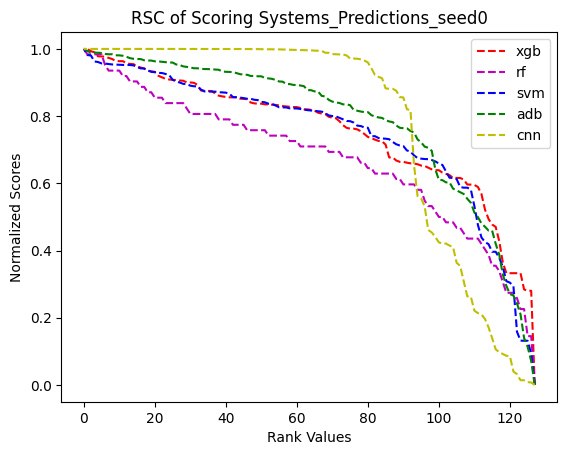

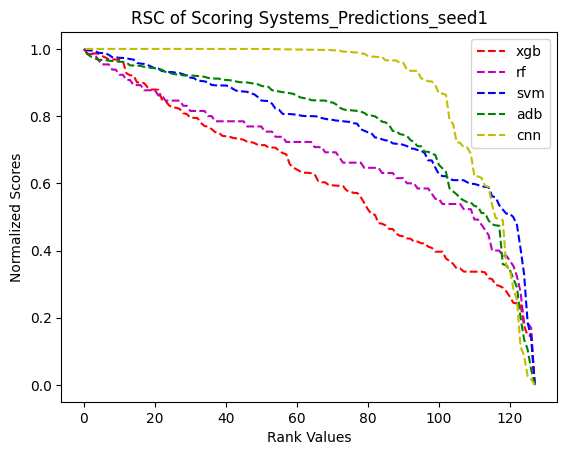

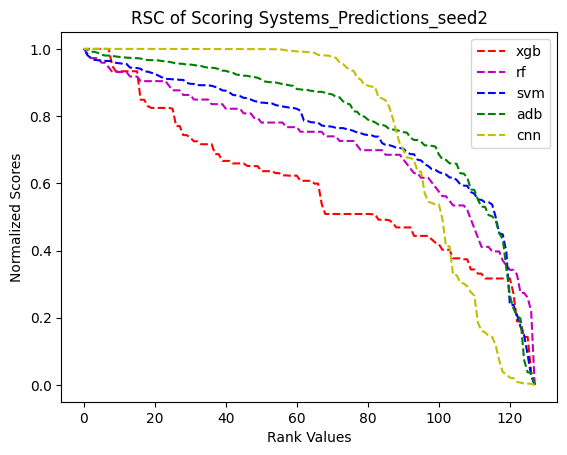

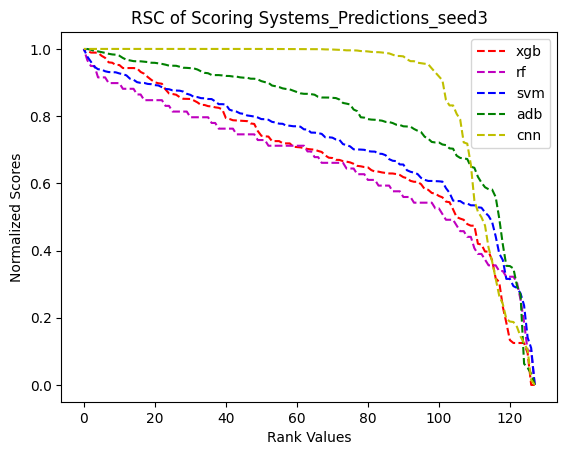

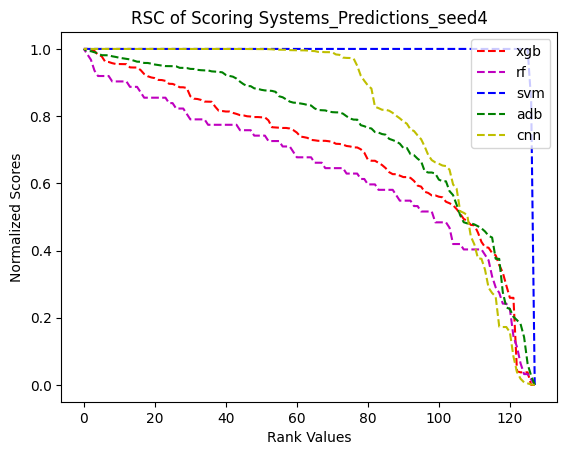

In [220]:
# RSC graphs
colors = ['r--', 'm--', 'b--', 'g--', 'y--']
ranks = np.flip(np.arange(len(predictions_xgb[0])))

for seed in range(len(globals()['predictions_list_%s' % sys])):
  for z in range(len(scoreSys)):
    globals()['line%s' % (z+1)] = plt.plot(ranks, np.sort(normalize(globals()['predictions_%s' % scoreSys[z]][seed])), colors[z], label = scoreSys[z])
    plt.legend(loc = 'upper right')
    plt.title('RSC of Scoring Systems_Predictions_seed%s' % seed)
    plt.xlabel('Rank Values')
    plt.ylabel('Normalized Scores')
  plt.show()


In [221]:
ds_score = [[] for _ in range(5)]

In [222]:
for sys in scoreSys:
  for seed in range(len(ds_score)):
    loc = scoreSys.index(sys)
    scoreSys.remove(sys)
    ds = 0
    for i in range(len(scoreSys)):
      ds += np.sum(np.square(normalize(np.sort(globals()['predictions_%s' % sys][seed]))-normalize(np.sort(globals()['predictions_%s' % scoreSys[i]][seed]))))
    ds = ds/len(scoreSys)
    scoreSys.insert(loc, sys)
    ds_score[seed].append(ds)

In [223]:
ds_score

[[1.5760756306295955,
  2.392492321730173,
  1.264857758546292,
  1.3491389318763845,
  3.96459318807885],
 [5.767847591409716,
  2.664243218509933,
  2.2543134387186368,
  2.1654107769532005,
  6.2936141091208375],
 [5.872402343315649,
  2.15162676065913,
  2.252467348712351,
  2.8665217476573557,
  5.184222428809263],
 [2.616068270770195,
  3.3703813262499804,
  1.9549069627393738,
  2.2941949369032235,
  6.010294940716247],
 [5.463121288407116,
  7.565251588437305,
  16.73813238931269,
  4.384292502358301,
  6.161509981530677]]

In [224]:
ds_rank = np.reciprocal(ds_score)

In [225]:
def get_auroc(y_pred_proba, y_test):
  res = metrics.roc_auc_score(y_test, y_pred_proba)
  return res

In [226]:
ps_score = [[] for _ in range(5)]

In [227]:
for sys in scoreSys:
  for seed in range(len(ps_score)):
    ps = get_auroc(globals()['predictions_%s' % sys][seed], y_test)
    ps_score[seed].append(ps)

In [228]:
ps_score

[[0.6042567342866645,
  0.6368473561689392,
  0.7070169604256734,
  0.6591286997006984,
  0.6405054871965413],
 [0.6311938809444629,
  0.6501496508147655,
  0.6887263052876621,
  0.6238776188892584,
  0.6380113069504489],
 [0.6109078816095777,
  0.6286997006983706,
  0.6684403059527769,
  0.6960425673428667,
  0.6233787828400398],
 [0.555703358829398,
  0.6774193548387096,
  0.6677751912204856,
  0.6315264383106084,
  0.6084137013634852],
 [0.6039241769205188,
  0.6489857000332557,
  0.4905221150648487,
  0.5560359161955437,
  0.5786498170934486]]

In [229]:
def powerset(s):
    x = len(s)
    ls = []
    for i in range(1 << x):
        ls.append([s[j] for j in range(x) if (i & (1 << j))])
    return ls[1:]

models = powerset(scoreSys)

def myFunc(e):
  return len(e)

models.sort(key=myFunc)

models_list = []
for i in range(len(models)):
  if len(models[i]) == 1:
    models_list.append(models[i][0])
  elif len(models[i]) == 2:
    models_list.append(models[i][0]+'&'+models[i][1])
  elif len(models[i]) == 3:
    models_list.append(models[i][0]+'&'+models[i][1]+'&'+models[i][2])
  elif len(models[i]) == 4:
    models_list.append(models[i][0]+'&'+models[i][1]+'&'+models[i][2]+'&'+models[i][3])
  elif len(models[i]) == 5:
    models_list.append(models[i][0]+'&'+models[i][1]+'&'+models[i][2]+'&'+models[i][3]+'&'+models[i][4])

# Perform average score combinations

In [230]:
avg_score_combine_seed1 = pd.DataFrame({'xgb':predictions_xgb[0], 'rf':predictions_rf[0], 'svm':predictions_svm[0], 'adb':predictions_adb[0], 'cnn':predictions_cnn[0]})
avg_score_combine_seed2 = pd.DataFrame({'xgb':predictions_xgb[1], 'rf':predictions_rf[1], 'svm':predictions_svm[1], 'adb':predictions_adb[1], 'cnn':predictions_cnn[1]})
avg_score_combine_seed3 = pd.DataFrame({'xgb':predictions_xgb[2], 'rf':predictions_rf[2], 'svm':predictions_svm[2], 'adb':predictions_adb[2], 'cnn':predictions_cnn[2]})
avg_score_combine_seed4 = pd.DataFrame({'xgb':predictions_xgb[3], 'rf':predictions_rf[3], 'svm':predictions_svm[3], 'adb':predictions_adb[3], 'cnn':predictions_cnn[3]})
avg_score_combine_seed5 = pd.DataFrame({'xgb':predictions_xgb[4], 'rf':predictions_rf[4], 'svm':predictions_svm[4], 'adb':predictions_adb[4], 'cnn':predictions_cnn[4]})

In [231]:
def avg_score_combine(models_list, single_score):
  for j in models_list[len(scoreSys):]:
    if len(j.split('&')) == 2:
      single_score[j] = (single_score[j.split('&')[0]]+single_score[j.split('&')[1]]) / 2
    elif len(j.split('&')) == 3:
      single_score[j] = (single_score[j.split('&')[0]]+single_score[j.split('&')[1]]+single_score[j.split('&')[2]]) / 3
    elif len(j.split('&')) == 4:
      single_score[j] = (single_score[j.split('&')[0]]+single_score[j.split('&')[1]]+single_score[j.split('&')[2]]+single_score[j.split('&')[3]]) / 4
    elif len(j.split('&')) == 5:
      single_score[j] = (single_score[j.split('&')[0]]+single_score[j.split('&')[1]]+single_score[j.split('&')[2]]+single_score[j.split('&')[3]]+single_score[j.split('&')[4]]) / 5

In [232]:
avg_score_combine(models_list, avg_score_combine_seed1)
avg_score_combine(models_list, avg_score_combine_seed2)
avg_score_combine(models_list, avg_score_combine_seed3)
avg_score_combine(models_list, avg_score_combine_seed4)
avg_score_combine(models_list, avg_score_combine_seed5)

# Perform average rank combinations

In [233]:
avg_rank_combine_seed1 = pd.DataFrame({'xgb':score_to_rank(predictions_xgb[0]), 'rf':score_to_rank(predictions_rf[0]), 'svm':score_to_rank(predictions_svm[0]), 'adb':score_to_rank(predictions_adb[0]), 'cnn':score_to_rank(predictions_cnn[0])})
avg_rank_combine_seed2 = pd.DataFrame({'xgb':score_to_rank(predictions_xgb[1]), 'rf':score_to_rank(predictions_rf[1]), 'svm':score_to_rank(predictions_svm[1]), 'adb':score_to_rank(predictions_adb[1]), 'cnn':score_to_rank(predictions_cnn[1])})
avg_rank_combine_seed3 = pd.DataFrame({'xgb':score_to_rank(predictions_xgb[2]), 'rf':score_to_rank(predictions_rf[2]), 'svm':score_to_rank(predictions_svm[2]), 'adb':score_to_rank(predictions_adb[2]), 'cnn':score_to_rank(predictions_cnn[2])})
avg_rank_combine_seed4 = pd.DataFrame({'xgb':score_to_rank(predictions_xgb[3]), 'rf':score_to_rank(predictions_rf[3]), 'svm':score_to_rank(predictions_svm[3]), 'adb':score_to_rank(predictions_adb[3]), 'cnn':score_to_rank(predictions_cnn[3])})
avg_rank_combine_seed5 = pd.DataFrame({'xgb':score_to_rank(predictions_xgb[4]), 'rf':score_to_rank(predictions_rf[4]), 'svm':score_to_rank(predictions_svm[4]), 'adb':score_to_rank(predictions_adb[4]), 'cnn':score_to_rank(predictions_cnn[4])})

In [234]:
def avg_rank_combine(models_list, single_rank):
  for j in models_list[len(scoreSys):]:
    if len(j.split('&')) == 2:
      single_rank[j+'_r'] = (single_rank[j.split('&')[0]]+single_rank[j.split('&')[1]]) / 2
    elif len(j.split('&')) == 3:
      single_rank[j+'_r'] = (single_rank[j.split('&')[0]]+single_rank[j.split('&')[1]]+single_rank[j.split('&')[2]]) / 3
    elif len(j.split('&')) == 4:
      single_rank[j+'_r'] = (single_rank[j.split('&')[0]]+single_rank[j.split('&')[1]]+single_rank[j.split('&')[2]]+single_rank[j.split('&')[3]]) / 4
    elif len(j.split('&')) == 5:
      single_rank[j+'_r'] = (single_rank[j.split('&')[0]]+single_rank[j.split('&')[1]]+single_rank[j.split('&')[2]]+single_rank[j.split('&')[3]]+single_rank[j.split('&')[4]]) / 5

In [235]:
avg_rank_combine(models_list, avg_rank_combine_seed1)
avg_rank_combine(models_list, avg_rank_combine_seed2)
avg_rank_combine(models_list, avg_rank_combine_seed3)
avg_rank_combine(models_list, avg_rank_combine_seed4)
avg_rank_combine(models_list, avg_rank_combine_seed5)

# Perform weighted score combination by diversity strength

In [236]:
ds_score_combine_seed1 = pd.DataFrame()
ds_score_combine_seed2 = pd.DataFrame()
ds_score_combine_seed3 = pd.DataFrame()
ds_score_combine_seed4 = pd.DataFrame()
ds_score_combine_seed5 = pd.DataFrame()

In [237]:
def ds_score_combine(models_list, single_score, ds_score_combine, ds_score):
  for j in models_list[len(scoreSys):]:
    if len(j.split('&')) == 2:
      ds_score_combine[j+'_ds'] = (single_score[j.split('&')[0]]*ds_score[scoreSys.index(j.split('&')[0])]+single_score[j.split('&')[1]]*ds_score[scoreSys.index(j.split('&')[1])])/(ds_score[scoreSys.index(j.split('&')[0])] + ds_score[scoreSys.index(j.split('&')[1])])
    elif len(j.split('&')) == 3:
      ds_score_combine[j+'_ds'] = (single_score[j.split('&')[0]]*ds_score[scoreSys.index(j.split('&')[0])]+single_score[j.split('&')[1]]*ds_score[scoreSys.index(j.split('&')[1])]+single_score[j.split('&')[2]]*ds_score[scoreSys.index(j.split('&')[2])])/(ds_score[scoreSys.index(j.split('&')[0])] + ds_score[scoreSys.index(j.split('&')[1])] + ds_score[scoreSys.index(j.split('&')[2])])
    elif len(j.split('&')) == 4:
      ds_score_combine[j+'_ds'] = (single_score[j.split('&')[0]]*ds_score[scoreSys.index(j.split('&')[0])]+single_score[j.split('&')[1]]*ds_score[scoreSys.index(j.split('&')[1])]+single_score[j.split('&')[2]]*ds_score[scoreSys.index(j.split('&')[2])]+single_score[j.split('&')[3]]*ds_score[scoreSys.index(j.split('&')[3])])/(ds_score[scoreSys.index(j.split('&')[0])] + ds_score[scoreSys.index(j.split('&')[1])] + ds_score[scoreSys.index(j.split('&')[2])] + ds_score[scoreSys.index(j.split('&')[3])])
    elif len(j.split('&')) == 5:
      ds_score_combine[j+'_ds'] = (single_score[j.split('&')[0]]*ds_score[scoreSys.index(j.split('&')[0])]+single_score[j.split('&')[1]]*ds_score[scoreSys.index(j.split('&')[1])]+single_score[j.split('&')[2]]*ds_score[scoreSys.index(j.split('&')[2])]+single_score[j.split('&')[3]]*ds_score[scoreSys.index(j.split('&')[3])]+single_score[j.split('&')[4]]*ds_score[scoreSys.index(j.split('&')[4])])/(ds_score[scoreSys.index(j.split('&')[0])] + ds_score[scoreSys.index(j.split('&')[1])] + ds_score[scoreSys.index(j.split('&')[2])] + ds_score[scoreSys.index(j.split('&')[3])] + ds_score[scoreSys.index(j.split('&')[4])])

In [238]:
ds_score_combine(models_list, avg_score_combine_seed1, ds_score_combine_seed1, ds_score[0])
ds_score_combine(models_list, avg_score_combine_seed2, ds_score_combine_seed2, ds_score[1])
ds_score_combine(models_list, avg_score_combine_seed3, ds_score_combine_seed3, ds_score[2])
ds_score_combine(models_list, avg_score_combine_seed4, ds_score_combine_seed4, ds_score[3])
ds_score_combine(models_list, avg_score_combine_seed5, ds_score_combine_seed5, ds_score[4])

# Perform weighted rank combination by diversity strength

In [239]:
ds_rank_combine_seed1 = pd.DataFrame()
ds_rank_combine_seed2 = pd.DataFrame()
ds_rank_combine_seed3 = pd.DataFrame()
ds_rank_combine_seed4 = pd.DataFrame()
ds_rank_combine_seed5 = pd.DataFrame()

In [240]:
def ds_rank_combine(models_list, single_rank, ds_rank_combine, ds_rank):
  for j in models_list[len(scoreSys):]:
    if len(j.split('&')) == 2:
      ds_rank_combine[j+'_ds_r'] = (single_rank[j.split('&')[0]]*ds_rank[scoreSys.index(j.split('&')[0])]+single_rank[j.split('&')[1]]*ds_rank[scoreSys.index(j.split('&')[1])])/(ds_rank[scoreSys.index(j.split('&')[0])] + ds_rank[scoreSys.index(j.split('&')[1])])
    elif len(j.split('&')) == 3:
      ds_rank_combine[j+'_ds_r'] = (single_rank[j.split('&')[0]]*ds_rank[scoreSys.index(j.split('&')[0])]+single_rank[j.split('&')[1]]*ds_rank[scoreSys.index(j.split('&')[1])]+single_rank[j.split('&')[2]]*ds_rank[scoreSys.index(j.split('&')[2])])/(ds_rank[scoreSys.index(j.split('&')[0])] + ds_rank[scoreSys.index(j.split('&')[1])] + ds_rank[scoreSys.index(j.split('&')[2])])
    elif len(j.split('&')) == 4:
      ds_rank_combine[j+'_ds_r'] = (single_rank[j.split('&')[0]]*ds_rank[scoreSys.index(j.split('&')[0])]+single_rank[j.split('&')[1]]*ds_rank[scoreSys.index(j.split('&')[1])]+single_rank[j.split('&')[2]]*ds_rank[scoreSys.index(j.split('&')[2])]+single_rank[j.split('&')[3]]*ds_rank[scoreSys.index(j.split('&')[3])])/(ds_rank[scoreSys.index(j.split('&')[0])] + ds_rank[scoreSys.index(j.split('&')[1])] + ds_rank[scoreSys.index(j.split('&')[2])] + ds_rank[scoreSys.index(j.split('&')[3])])
    elif len(j.split('&')) == 5:
      ds_rank_combine[j+'_ds_r'] = (single_rank[j.split('&')[0]]*ds_rank[scoreSys.index(j.split('&')[0])]+single_rank[j.split('&')[1]]*ds_rank[scoreSys.index(j.split('&')[1])]+single_rank[j.split('&')[2]]*ds_rank[scoreSys.index(j.split('&')[2])]+single_rank[j.split('&')[3]]*ds_rank[scoreSys.index(j.split('&')[3])]+single_rank[j.split('&')[4]]*ds_rank[scoreSys.index(j.split('&')[4])])/(ds_rank[scoreSys.index(j.split('&')[0])] + ds_rank[scoreSys.index(j.split('&')[1])] + ds_rank[scoreSys.index(j.split('&')[2])] + ds_rank[scoreSys.index(j.split('&')[3])] + ds_rank[scoreSys.index(j.split('&')[4])])

In [241]:
ds_rank_combine(models_list, avg_rank_combine_seed1, ds_rank_combine_seed1, ds_rank[0])
ds_rank_combine(models_list, avg_rank_combine_seed2, ds_rank_combine_seed2, ds_rank[1])
ds_rank_combine(models_list, avg_rank_combine_seed3, ds_rank_combine_seed3, ds_rank[2])
ds_rank_combine(models_list, avg_rank_combine_seed4, ds_rank_combine_seed4, ds_rank[3])
ds_rank_combine(models_list, avg_rank_combine_seed5, ds_rank_combine_seed5, ds_rank[4])

# Perform weighted score combination by performance strength (AUROC)

In [242]:
ps_score_combine_seed1 = pd.DataFrame()
ps_score_combine_seed2 = pd.DataFrame()
ps_score_combine_seed3 = pd.DataFrame()
ps_score_combine_seed4 = pd.DataFrame()
ps_score_combine_seed5 = pd.DataFrame()

In [243]:
def ps_score_combine(models_list, single_score, ps_score_combine, ps_score):
  for j in models_list[len(scoreSys):]:
    if len(j.split('&')) == 2:
      ps_score_combine[j+'_ps'] = (single_score[j.split('&')[0]]*(ps_score[scoreSys.index(j.split('&')[0])])+single_score[j.split('&')[1]]*(ps_score[scoreSys.index(j.split('&')[1])]))/(ps_score[scoreSys.index(j.split('&')[0])] + ps_score[scoreSys.index(j.split('&')[1])])
    elif len(j.split('&')) == 3:
      ps_score_combine[j+'_ps'] = (single_score[j.split('&')[0]]*(ps_score[scoreSys.index(j.split('&')[0])])+single_score[j.split('&')[1]]*(ps_score[scoreSys.index(j.split('&')[1])])+single_score[j.split('&')[2]]*(ps_score[scoreSys.index(j.split('&')[2])]))/(ps_score[scoreSys.index(j.split('&')[0])] + ps_score[scoreSys.index(j.split('&')[1])] + ps_score[scoreSys.index(j.split('&')[2])])
    elif len(j.split('&')) == 4:
      ps_score_combine[j+'_ps'] = (single_score[j.split('&')[0]]*(ps_score[scoreSys.index(j.split('&')[0])])+single_score[j.split('&')[1]]*(ps_score[scoreSys.index(j.split('&')[1])])+single_score[j.split('&')[2]]*(ps_score[scoreSys.index(j.split('&')[2])])+single_score[j.split('&')[3]]*(ps_score[scoreSys.index(j.split('&')[3])]))/(ps_score[scoreSys.index(j.split('&')[0])] + ps_score[scoreSys.index(j.split('&')[1])] + ps_score[scoreSys.index(j.split('&')[2])] + ps_score[scoreSys.index(j.split('&')[3])])
    elif len(j.split('&')) == 5:
      ps_score_combine[j+'_ps'] = (single_score[j.split('&')[0]]*(ps_score[scoreSys.index(j.split('&')[0])])+single_score[j.split('&')[1]]*(ps_score[scoreSys.index(j.split('&')[1])])+single_score[j.split('&')[2]]*(ps_score[scoreSys.index(j.split('&')[2])])+single_score[j.split('&')[3]]*(ps_score[scoreSys.index(j.split('&')[3])])+single_score[j.split('&')[4]]*(ps_score[scoreSys.index(j.split('&')[4])]))/(ps_score[scoreSys.index(j.split('&')[0])] + ps_score[scoreSys.index(j.split('&')[1])] + ps_score[scoreSys.index(j.split('&')[2])] + ps_score[scoreSys.index(j.split('&')[3])] + ps_score[scoreSys.index(j.split('&')[4])])

In [244]:
ps_score_combine(models_list, avg_score_combine_seed1, ps_score_combine_seed1, ps_score[0])
ps_score_combine(models_list, avg_score_combine_seed2, ps_score_combine_seed2, ps_score[1])
ps_score_combine(models_list, avg_score_combine_seed3, ps_score_combine_seed3, ps_score[2])
ps_score_combine(models_list, avg_score_combine_seed4, ps_score_combine_seed4, ps_score[3])
ps_score_combine(models_list, avg_score_combine_seed5, ps_score_combine_seed5, ps_score[4])

# Perform weighted rank combination by performance strength

In [245]:
ps_rank_combine_seed1 = pd.DataFrame()
ps_rank_combine_seed2 = pd.DataFrame()
ps_rank_combine_seed3 = pd.DataFrame()
ps_rank_combine_seed4 = pd.DataFrame()
ps_rank_combine_seed5 = pd.DataFrame()

In [246]:
def ps_rank_combine(models_list, single_rank, ps_rank_combine, ps_score):
  for j in models_list[len(scoreSys):]:
    if len(j.split('&')) == 2:
      ps_rank_combine[j+'_ps_r'] = (single_rank[j.split('&')[0]]*(1 / ps_score[scoreSys.index(j.split('&')[0])])+single_rank[j.split('&')[1]]*(1 / ps_score[scoreSys.index(j.split('&')[1])]))/(1 / ps_score[scoreSys.index(j.split('&')[0])] + 1 / ps_score[scoreSys.index(j.split('&')[1])])
    elif len(j.split('&')) == 3:
      ps_rank_combine[j+'_ps_r'] = (single_rank[j.split('&')[0]]*(1 / ps_score[scoreSys.index(j.split('&')[0])])+single_rank[j.split('&')[1]]*(1 / ps_score[scoreSys.index(j.split('&')[1])])+single_rank[j.split('&')[2]]*(1 / ps_score[scoreSys.index(j.split('&')[2])]))/(1 / ps_score[scoreSys.index(j.split('&')[0])] + 1 / ps_score[scoreSys.index(j.split('&')[1])] + 1 / ps_score[scoreSys.index(j.split('&')[2])])
    elif len(j.split('&')) == 4:
      ps_rank_combine[j+'_ps_r'] = (single_rank[j.split('&')[0]]*(1 / ps_score[scoreSys.index(j.split('&')[0])])+single_rank[j.split('&')[1]]*(1 / ps_score[scoreSys.index(j.split('&')[1])])+single_rank[j.split('&')[2]]*(1 / ps_score[scoreSys.index(j.split('&')[2])])+single_rank[j.split('&')[3]]*(1 / ps_score[scoreSys.index(j.split('&')[3])]))/(1 / ps_score[scoreSys.index(j.split('&')[0])] + 1 / ps_score[scoreSys.index(j.split('&')[1])] + 1 / ps_score[scoreSys.index(j.split('&')[2])] + 1 / ps_score[scoreSys.index(j.split('&')[3])])
    elif len(j.split('&')) == 5:
      ps_rank_combine[j+'_ps_r'] = (single_rank[j.split('&')[0]]*(1 / ps_score[scoreSys.index(j.split('&')[0])])+single_rank[j.split('&')[1]]*(1 / ps_score[scoreSys.index(j.split('&')[1])])+single_rank[j.split('&')[2]]*(1 / ps_score[scoreSys.index(j.split('&')[2])])+single_rank[j.split('&')[3]]*(1 / ps_score[scoreSys.index(j.split('&')[3])])+single_rank[j.split('&')[4]]*(1 / ps_score[scoreSys.index(j.split('&')[4])]))/(1 / ps_score[scoreSys.index(j.split('&')[0])] + 1 / ps_score[scoreSys.index(j.split('&')[1])] + 1 / ps_score[scoreSys.index(j.split('&')[2])] + 1 / ps_score[scoreSys.index(j.split('&')[3])] + 1 / ps_score[scoreSys.index(j.split('&')[4])])

In [247]:
ps_rank_combine(models_list, avg_rank_combine_seed1, ps_rank_combine_seed1, ps_score[0])
ps_rank_combine(models_list, avg_rank_combine_seed2, ps_rank_combine_seed2, ps_score[1])
ps_rank_combine(models_list, avg_rank_combine_seed3, ps_rank_combine_seed3, ps_score[2])
ps_rank_combine(models_list, avg_rank_combine_seed4, ps_rank_combine_seed4, ps_score[3])
ps_rank_combine(models_list, avg_rank_combine_seed5, ps_rank_combine_seed5, ps_score[4])

In [248]:
avg_rank_combine_seed1.rename(columns={'xgb': 'xgb_r', 'rf': 'rf_r', 'svm': 'svm_r', 'adb': 'adb_r', 'cnn': 'cnn_r'}, inplace=True)
avg_rank_combine_seed2.rename(columns={'xgb': 'xgb_r', 'rf': 'rf_r', 'svm': 'svm_r', 'adb': 'adb_r', 'cnn': 'cnn_r'}, inplace=True)
avg_rank_combine_seed3.rename(columns={'xgb': 'xgb_r', 'rf': 'rf_r', 'svm': 'svm_r', 'adb': 'adb_r', 'cnn': 'cnn_r'}, inplace=True)
avg_rank_combine_seed4.rename(columns={'xgb': 'xgb_r', 'rf': 'rf_r', 'svm': 'svm_r', 'adb': 'adb_r', 'cnn': 'cnn_r'}, inplace=True)
avg_rank_combine_seed5.rename(columns={'xgb': 'xgb_r', 'rf': 'rf_r', 'svm': 'svm_r', 'adb': 'adb_r', 'cnn': 'cnn_r'}, inplace=True)

# Calculate AUROC

In [250]:
score_combine_list = np.hstack((np.array(avg_score_combine_seed1.columns), np.array(ds_score_combine_seed1.columns), np.array(ps_score_combine_seed1.columns)))
AUROC = pd.DataFrame(index = score_combine_list)
for i in range(1, 6):
  auroc_avg, auroc_ds, auroc_ps = [], [], []
  for col in globals()['avg_score_combine_seed%s' %i].columns:
    auroc_score = get_auroc(np.array(globals()['avg_score_combine_seed%s' %i][col]), y_test)
    auroc_avg.append(auroc_score)
  for col in globals()['ds_score_combine_seed%s' %i].columns:
    auroc_score = get_auroc(np.array(globals()['ds_score_combine_seed%s' %i][col]), y_test)
    auroc_ds.append(auroc_score)
  for col in globals()['ps_score_combine_seed%s' %i].columns:
    auroc_score = get_auroc(np.array(globals()['ps_score_combine_seed%s' %i][col]), y_test)
    auroc_ps.append(auroc_score)
  AUROC['seed'+str(i)] = np.hstack((auroc_avg, auroc_ds, auroc_ps))

In [251]:
pd.set_option('display.max_rows', None)

In [252]:
AUROC['avg_AUROC'] = AUROC.mean(axis=1)

In [255]:
AUROC.sort_values(by='avg_AUROC', ascending=False)

,seed1,seed2,seed3,seed4,seed5,avg_AUROC
rf&svm&adb_ds,0.685733,0.680745,0.716661,0.694047,0.654140,0.686265
rf&svm&adb_ps,0.692717,0.682408,0.713003,0.696375,0.641836,0.685268
xgb&rf&svm&adb_ps,0.688726,0.685733,0.715331,0.682075,0.654140,0.685201
xgb&rf&svm&adb_ds,0.676089,0.682075,0.714333,0.677752,0.672431,0.684536
rf&svm&adb,0.691719,0.681077,0.712670,0.695710,0.640505,0.684337
xgb&rf&svm&adb,0.686731,0.685401,0.711340,0.678750,0.649485,0.682341
xgb&rf&svm&adb&cnn_ps,0.682408,0.699036,0.706684,0.671433,0.642168,0.680346
xgb&rf&adb_ds,0.670768,0.678750,0.712338,0.669105,0.669105,0.680013
xgb&rf&adb_ps,0.675424,0.676754,0.719322,0.668108,0.658464,0.679614
rf&adb_ds,0.672764,0.672098,0.717991,0.684071,0.648819,0.679149
